<a href="https://colab.research.google.com/github/Homabeyrami/ML_Project_Pra/blob/main/Kaggle_Competitions_Version_2_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
!pip install optuna
!pip install catboost

import numpy as np
import pandas as pd
from scipy.stats import trim_mean, kurtosis, skew, boxcox, yeojohnson
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import optuna

import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)



import warnings

# Load the Dataset

In [ ]:
!gdown --id 1fL21l_lxUMeSAFfwGPAAa4oVuRBOkX5h
!gdown --id 1jQ7FRg5oSPq3gslczSUDsrpi6uZw3QX0
!gdown --id 1I1rTXk3t8Kr_q3G_gI9DNsSw113mQYto

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fL21l_lxUMeSAFfwGPAAa4oVuRBOkX5h
To: /content/original.csv
100% 517k/517k [00:00<00:00, 138MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jQ7FRg5oSPq3gslczSUDsrpi6uZw3QX0
To: /content/train.csv
100% 9.49M/9.49M [00:00<00:00, 23.6MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.go

In [ ]:
# Load test Data
test = pd.read_csv('test.csv')

#Train Data
data = pd.read_csv('train.csv')

#Original Data
Original = pd.read_csv('original.csv')

# Dataset Overview

In [ ]:
print(f'Train data from competition:\nShape:\n{data.shape}')
print('=============================')
print(f'Original data:\nShape:\n{Original.shape}')
print('=============================')
print(f'test data:\nShape:\n{test.shape}')

Train data from competition:
Shape:
(76518, 38)
Original data:
Shape:
(4424, 38)
test data:
Shape:
(51012, 37)


In [ ]:
# drop id column
data = data.drop(columns=['id'])
Original = Original.drop(columns=['id'])

In [ ]:
# Identify columns that do not match
columns_data = set(data.columns)
columns_Original = set(Original.columns)

# Columns in df1 not in df2
diff_df1 = columns_data - columns_Original
# Columns in df2 not in df1
diff_df2 = columns_Original - columns_data

# Print the differences
print("Columns in dataset 1 but not in dataset 2:", diff_df1)
print("Columns in dataset 2 but not in dataset 1:", diff_df2)

# Create a mapping for renaming columns if needed
rename_mapping_Original = {
    'Daytime/evening attendance\t': 'Daytime/evening attendance',
}

# Rename the columns in the datasets
Original.rename(columns=rename_mapping_Original, inplace=True)


# Check if columns match now
columns_data = set(data.columns)
columns_Original = set(Original.columns)


if columns_data == columns_Original:
    print("Columns match, ready to merge or concatenate.")
else:
    print("Columns still do not match. Manual intervention required.")

# Merge or concatenate the datasets
# Assuming we want to concatenate them vertically
data = pd.concat([data, Original], axis = 0)
data = data.reset_index(drop=True)
print("Datasets merged successfully")

Columns in dataset 1 but not in dataset 2: {'Daytime/evening attendance'}
Columns in dataset 2 but not in dataset 1: {'Daytime/evening attendance\t'}
Columns match, ready to merge or concatenate.
Datasets merged successfully


In [ ]:
print(f'The Shape of Train Dataset after merging:\nNumber of rows: {data.shape[0]}\nNumber of columns: {data.shape[1]}')

The Shape of Train Dataset after merging:
Number of rows: 80942
Number of columns: 37


###Columns Definition:

1. **Marital status**: Indicates the marital status of the student (e.g., Single, Married, Divorced).

2. **Application mode**: Refers to the method through which the student applied to the institution (e.g., Online, In-person).

3. **Application order**: Indicates the order of applications the student made (e.g., first choice, second choice).

4. **Course**: The specific course or program the student is enrolled in.

5. **Daytime/evening attendance**: Specifies whether the student attends classes during the day or in the evening.

6. **Previous qualification**: The highest qualification the student had before enrolling in the current course (e.g., High School Diploma, Bachelor's Degree).

7. **Previous qualification (grade)**: The grade or GPA of the student's previous qualification.

8. **Nationality**: The nationality of the student.

9. **Mother's qualification**: The highest level of education attained by the student's mother.

10. **Father's qualification**: The highest level of education attained by the student's father.

11. **Mother's occupation**: The occupation of the student's mother.

12. **Father's occupation**: The occupation of the student's father.

13. **Admission grade**: The grade or score the student received upon admission to the course or institution.

14. **Displaced**: Indicates whether the student is living away from home for the purpose of study (e.g., Yes, No).

15. **Educational special needs**: Specifies whether the student has any educational special needs (e.g., Yes, No).

16. **Debtor**: Indicates whether the student has outstanding debts to the institution (e.g., Yes, No).

17. **Tuition fees up to date**: Specifies whether the student's tuition fees are paid up to date (e.g., Yes, No).

18. **Gender**: The gender of the student (e.g., Male, Female, Other).

19. **Scholarship holder**: Indicates whether the student is a scholarship recipient (e.g., Yes, No).

20. **Age at enrollment**: The age of the student when they enrolled in the course.

21. **International**: Indicates whether the student is an international student (e.g., Yes, No).

22. **Curricular units 1st sem (credited)**: The number of credits the student was awarded for courses in the first semester.

23. **Curricular units 1st sem (enrolled)**: The number of curricular units or courses the student was enrolled in during the first semester.

24. **Curricular units 1st sem (evaluations)**: The number of evaluations (e.g., exams, tests) the student underwent in the first semester.

25. **Curricular units 1st sem (approved)**: The number of curricular units or courses the student passed in the first semester.

26. **Curricular units 1st sem (grade)**: The average grade or score the student received for courses in the first semester.

27. **Curricular units 1st sem (without evaluations)**: The number of curricular units or courses in the first semester for which the student did not undergo evaluations.

28. **Curricular units 2nd sem (credited)**: The number of credits the student was awarded for courses in the second semester.

29. **Curricular units 2nd sem (enrolled)**: The number of curricular units or courses the student was enrolled in during the second semester.

30. **Curricular units 2nd sem (evaluations)**: The number of evaluations (e.g., exams, tests) the student underwent in the second semester.

31. **Curricular units 2nd sem (approved)**: The number of curricular units or courses the student passed in the second semester.

32. **Curricular units 2nd sem (grade)**: The average grade or score the student received for courses in the second semester.

33. **Curricular units 2nd sem (without evaluations)**: The number of curricular units or courses in the second semester for which the student did not undergo evaluations.

34. **Unemployment rate**: The unemployment rate in the region or country, which might influence the student's economic situation and decisions.

35. **Inflation rate**: The inflation rate in the region or country, which could impact the cost of living and studying.

36. **GDP**: The Gross Domestic Product of the region or country, indicating the overall economic health.

37. **Target**: The target variable that indicates whether the student has dropped out or succeeded. This could be a binary variable (e.g., 0 for success, 1 for dropout) or could have multiple categories.


In [ ]:
print("Few rows of the train dataset:")
data.head(5)

Few rows of the train dataset:


Marital status  Application mode  Application order  Course  \
0               1                 1                  1    9238   
1               1                17                  1    9238   
2               1                17                  2    9254   
3               1                 1                  3    9500   
4               1                 1                  2    9500   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           126.0            1                       1   
1                           125.0            1                      19   
2                           137.0            1                       3   
3                           131.0            1                      19   
4                           132.0            1                      19   

   Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                      19  ...                                    0   
1                      19  ...                                    0   
2                      19  ...                                    0   
3                       3  ...                                    0   
4                      37  ...                                    0   

   Curricular units 2nd sem (enrolled)  \
0                                    6   
1                                    6   
2                                    6   
3                                    8   
4                                    7   

   Curricular units 2nd sem (evaluations)  \
0                                       7   
1                                       9   
2                                       0   
3                                      11   
4                                      12   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    6                         12.428571   
1                                    0                          0.000000   
2                                    0                          0.000000   
3                                    7                         12.820000   
4                                    6                         12.933333   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               11.1   
1                                               0               11.1   
2                                               0               16.2   
3                                               0               11.1   
4                                               0                7.6   

   Inflation rate   GDP    Target  
0             0.6  2.02  Graduate  
1             0.6  2.02   Dropout  
2             0.3 -0.92   Dropout  
3             0.6  2.02  Enrolled  
4             2.6  0.32  Graduate  

[5 rows x 37 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80942 entries, 0 to 80941
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  80942 non-null  int64  
 1   Application mode                                80942 non-null  int64  
 2   Application order                               80942 non-null  int64  
 3   Course                                          80942 non-null  int64  
 4   Daytime/evening attendance                      80942 non-null  int64  
 5   Previous qualification                          80942 non-null  int64  
 6   Previous qualification (grade)                  80942 non-null  float64
 7   Nacionality                                     80942 non-null  int64  
 8   Mother's qualification                          80942 non-null  int64  
 9   Father's qualification                 

In [ ]:
submission_id = test.id
test = test.drop(columns=['id'])

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51012 entries, 0 to 51011
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  51012 non-null  int64  
 1   Application mode                                51012 non-null  int64  
 2   Application order                               51012 non-null  int64  
 3   Course                                          51012 non-null  int64  
 4   Daytime/evening attendance                      51012 non-null  int64  
 5   Previous qualification                          51012 non-null  int64  
 6   Previous qualification (grade)                  51012 non-null  float64
 7   Nacionality                                     51012 non-null  int64  
 8   Mother's qualification                          51012 non-null  int64  
 9   Father's qualification                 

In [ ]:
print(f'Null values in each column in train dara:\n{data.isnull().sum()}')
print('========================================')
print(f'Null values in each column in test dara:\n{test.isnull().sum()}')

Null values in each column in train dara:
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder    

In [ ]:
data.duplicated().sum()

0

In [ ]:
print(f'Unique values in train data:\n{data.nunique()}')

Unique values in train data:
Marital status                                       6
Application mode                                    23
Application order                                    8
Course                                              19
Daytime/evening attendance                           2
Previous qualification                              21
Previous qualification (grade)                     114
Nacionality                                         21
Mother's qualification                              35
Father's qualification                              39
Mother's occupation                                 40
Father's occupation                                 56
Admission grade                                    669
Displaced                                            2
Educational special needs                            2
Debtor                                               2
Tuition fees up to date                              2
Gender                              

In [ ]:
# identify numeric features
numerical_col = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
                 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
                 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
                 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)',
                 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
                 'Unemployment rate', 'Inflation rate', 'GDP']

# Get the list of all columns in the dataset
all_columns = data.columns

# Identify the categorical columns by removing numerical columns from all_columns
categorical_col = [col for col in all_columns if col not in numerical_col]

In [ ]:
print("\nSummary statistics for numerical features in train data:")
data[numerical_col].describe().T


Summary statistics for numerical features in train data:


count        mean  \
Previous qualification (grade)                  80942.0  132.391585   
Admission grade                                 80942.0  125.452195   
Age at enrollment                               80942.0   22.332571   
Curricular units 1st sem (credited)             80942.0    0.217353   
Curricular units 1st sem (enrolled)             80942.0    5.912233   
Curricular units 1st sem (evaluations)          80942.0    7.404104   
Curricular units 1st sem (approved)             80942.0    4.207383   
Curricular units 1st sem (grade)                80942.0   10.031113   
Curricular units 1st sem (without evaluations)  80942.0    0.062316   
Curricular units 2nd sem (credited)             80942.0    0.159176   
Curricular units 2nd sem (enrolled)             80942.0    5.949742   
Curricular units 2nd sem (evaluations)          80942.0    7.279768   
Curricular units 2nd sem (approved)             80942.0    4.030627   
Curricular units 2nd sem (grade)                80942.0    9.659104   
Curricular units 2nd sem (without evaluations)  80942.0    0.067246   
Unemployment rate                               80942.0   11.522844   
Inflation rate                                  80942.0    1.228208   
GDP                                             80942.0   -0.076391   

                                                      std    min         25%  \
Previous qualification (grade)                  11.126395  95.00  125.000000   
Admission grade                                 12.679973  95.00  118.000000   
Age at enrollment                                6.932819  17.00   18.000000   
Curricular units 1st sem (credited)              1.274493   0.00    0.000000   
Curricular units 1st sem (enrolled)              1.727900   0.00    5.000000   
Curricular units 1st sem (evaluations)           3.554723   0.00    6.000000   
Curricular units 1st sem (approved)              2.714405   0.00    2.000000   
Curricular units 1st sem (grade)                 5.244131   0.00   10.666667   
Curricular units 1st sem (without evaluations)   0.429133   0.00    0.000000   
Curricular units 2nd sem (credited)              1.016847   0.00    0.000000   
Curricular units 2nd sem (enrolled)              1.664669   0.00    5.000000   
Curricular units 2nd sem (evaluations)           3.533806   0.00    6.000000   
Curricular units 2nd sem (approved)              2.788397   0.00    1.000000   
Curricular units 2nd sem (grade)                 5.529912   0.00   10.000000   
Curricular units 2nd sem (without evaluations)   0.483030   0.00    0.000000   
Unemployment rate                                2.653953   7.60    9.400000   
Inflation rate                                   1.397932  -0.80    0.300000   
GDP                                              2.252464  -4.06   -1.700000   

                                                       50%         75%  \
Previous qualification (grade)                  133.100000  140.000000   
Admission grade                                 124.700000  132.100000   
Age at enrollment                                19.000000   23.000000   
Curricular units 1st sem (credited)               0.000000    0.000000   
Curricular units 1st sem (enrolled)               6.000000    6.000000   
Curricular units 1st sem (evaluations)            7.000000    9.000000   
Curricular units 1st sem (approved)               5.000000    6.000000   
Curricular units 1st sem (grade)                 12.166667   13.327143   
Curricular units 1st sem (without evaluations)    0.000000    0.000000   
Curricular units 2nd sem (credited)               0.000000    0.000000   
Curricular units 2nd sem (enrolled)               6.000000    6.000000   
Curricular units 2nd sem (evaluations)            8.000000    9.000000   
Curricular units 2nd sem (approved)               5.000000    6.000000   
Curricular units 2nd sem (grade)                 12.142857   13.250000   
Curricular units 2nd sem (without evaluations)    0.000000    0.00000

In [ ]:
print("\nSummary statistics for numerical features in test data:")
test[numerical_col].describe().T


Summary statistics for numerical features in test data:


count        mean  \
Previous qualification (grade)                  51012.0  132.328001   
Admission grade                                 51012.0  125.419794   
Age at enrollment                               51012.0   22.206971   
Curricular units 1st sem (credited)             51012.0    0.182055   
Curricular units 1st sem (enrolled)             51012.0    5.903376   
Curricular units 1st sem (evaluations)          51012.0    7.392417   
Curricular units 1st sem (approved)             51012.0    4.217655   
Curricular units 1st sem (grade)                51012.0   10.088485   
Curricular units 1st sem (without evaluations)  51012.0    0.057810   
Curricular units 2nd sem (credited)             51012.0    0.129283   
Curricular units 2nd sem (enrolled)             51012.0    5.944131   
Curricular units 2nd sem (evaluations)          51012.0    7.274092   
Curricular units 2nd sem (approved)             51012.0    4.039697   
Curricular units 2nd sem (grade)                51012.0    9.709128   
Curricular units 2nd sem (without evaluations)  51012.0    0.063809   
Unemployment rate                               51012.0   11.520611   
Inflation rate                                  51012.0    1.228719   
GDP                                             51012.0   -0.086477   

                                                      std    min     25%  \
Previous qualification (grade)                  10.885679  95.00  125.00   
Admission grade                                 12.598137  95.00  118.00   
Age at enrollment                                6.760468  17.00   18.00   
Curricular units 1st sem (credited)              1.145390   0.00    0.00   
Curricular units 1st sem (enrolled)              1.639316   0.00    5.00   
Curricular units 1st sem (evaluations)           3.458179   0.00    6.00   
Curricular units 1st sem (approved)              2.666393   0.00    2.00   
Curricular units 1st sem (grade)                 5.215587   0.00   10.75   
Curricular units 1st sem (without evaluations)   0.403434   0.00    0.00   
Curricular units 2nd sem (credited)              0.877250   0.00    0.00   
Curricular units 2nd sem (enrolled)              1.599746   0.00    5.00   
Curricular units 2nd sem (evaluations)           3.433149   0.00    6.00   
Curricular units 2nd sem (approved)              2.749871   0.00    1.00   
Curricular units 2nd sem (grade)                 5.496810   0.00   10.00   
Curricular units 2nd sem (without evaluations)   0.467176   0.00    0.00   
Unemployment rate                                2.651113   7.60    9.40   
Inflation rate                                   1.402773  -0.80    0.30   
GDP                                              2.251650  -4.06   -1.70   

                                                       50%         75%  \
Previous qualification (grade)                  133.100000  139.000000   
Admission grade                                 124.600000  132.000000   
Age at enrollment                                19.000000   23.000000   
Curricular units 1st sem (credited)               0.000000    0.000000   
Curricular units 1st sem (enrolled)               6.000000    6.000000   
Curricular units 1st sem (evaluations)            7.000000    9.000000   
Curricular units 1st sem (approved)               5.000000    6.000000   
Curricular units 1st sem (grade)                 12.200000   13.333333   
Curricular units 1st sem (without evaluations)    0.000000    0.000000   
Curricular units 2nd sem (credited)               0.000000    0.000000   
Curricular units 2nd sem (enrolled)               6.000000    6.000000   
Curricular units 2nd sem (evaluations)            8.000000    9.000000   
Curricular units 2nd sem (approved)               5.000000    6.000000   
Curricular units 2nd sem (grade)                 12.166667   13.250000   
Curricular units 2nd sem (without evaluations)    0.000000    0.000000   
Unemployment rate                                11.100000   12.700000 

# EDA

## Univariate Analysis

In [ ]:
print('mean vs trimmed_mean in the train data')


# Calculate mean and trimmed mean for each numeric columns
mean_vs_trimmed_mean = pd.DataFrame({'mean': data[numerical_col].mean(),
                                     'trimmed_mean': data[numerical_col].apply(lambda x: trim_mean(x, proportiontocut=0.1))})


print("Mean vs Trimmed Mean:")
print(mean_vs_trimmed_mean)

print('===================================================================================')
print('mean vs trimmed_mean in the test data')

# Calculate mean and trimmed mean for each numeric columns
mean_vs_trimmed_mean = pd.DataFrame({'mean': test[numerical_col].mean(),
                                     'trimmed_mean': test[numerical_col].apply(lambda x: trim_mean(x, proportiontocut=0.1))})

print("Mean vs Trimmed Mean:")
print(mean_vs_trimmed_mean)

mean vs trimmed_mean in the train data
Mean vs Trimmed Mean:
                                                      mean  trimmed_mean
Previous qualification (grade)                  132.391585    132.127262
Admission grade                                 125.452195    125.070186
Age at enrollment                                22.332571     20.672808
Curricular units 1st sem (credited)               0.217353      0.000000
Curricular units 1st sem (enrolled)               5.912233      5.892949
Curricular units 1st sem (evaluations)            7.404104      7.525234
Curricular units 1st sem (approved)               4.207383      4.257405
Curricular units 1st sem (grade)                 10.031113     10.699736
Curricular units 1st sem (without evaluations)    0.062316      0.000000
Curricular units 2nd sem (credited)               0.159176      0.000000
Curricular units 2nd sem (enrolled)               5.949742      5.955879
Curricular units 2nd sem (evaluations)            7.279768     

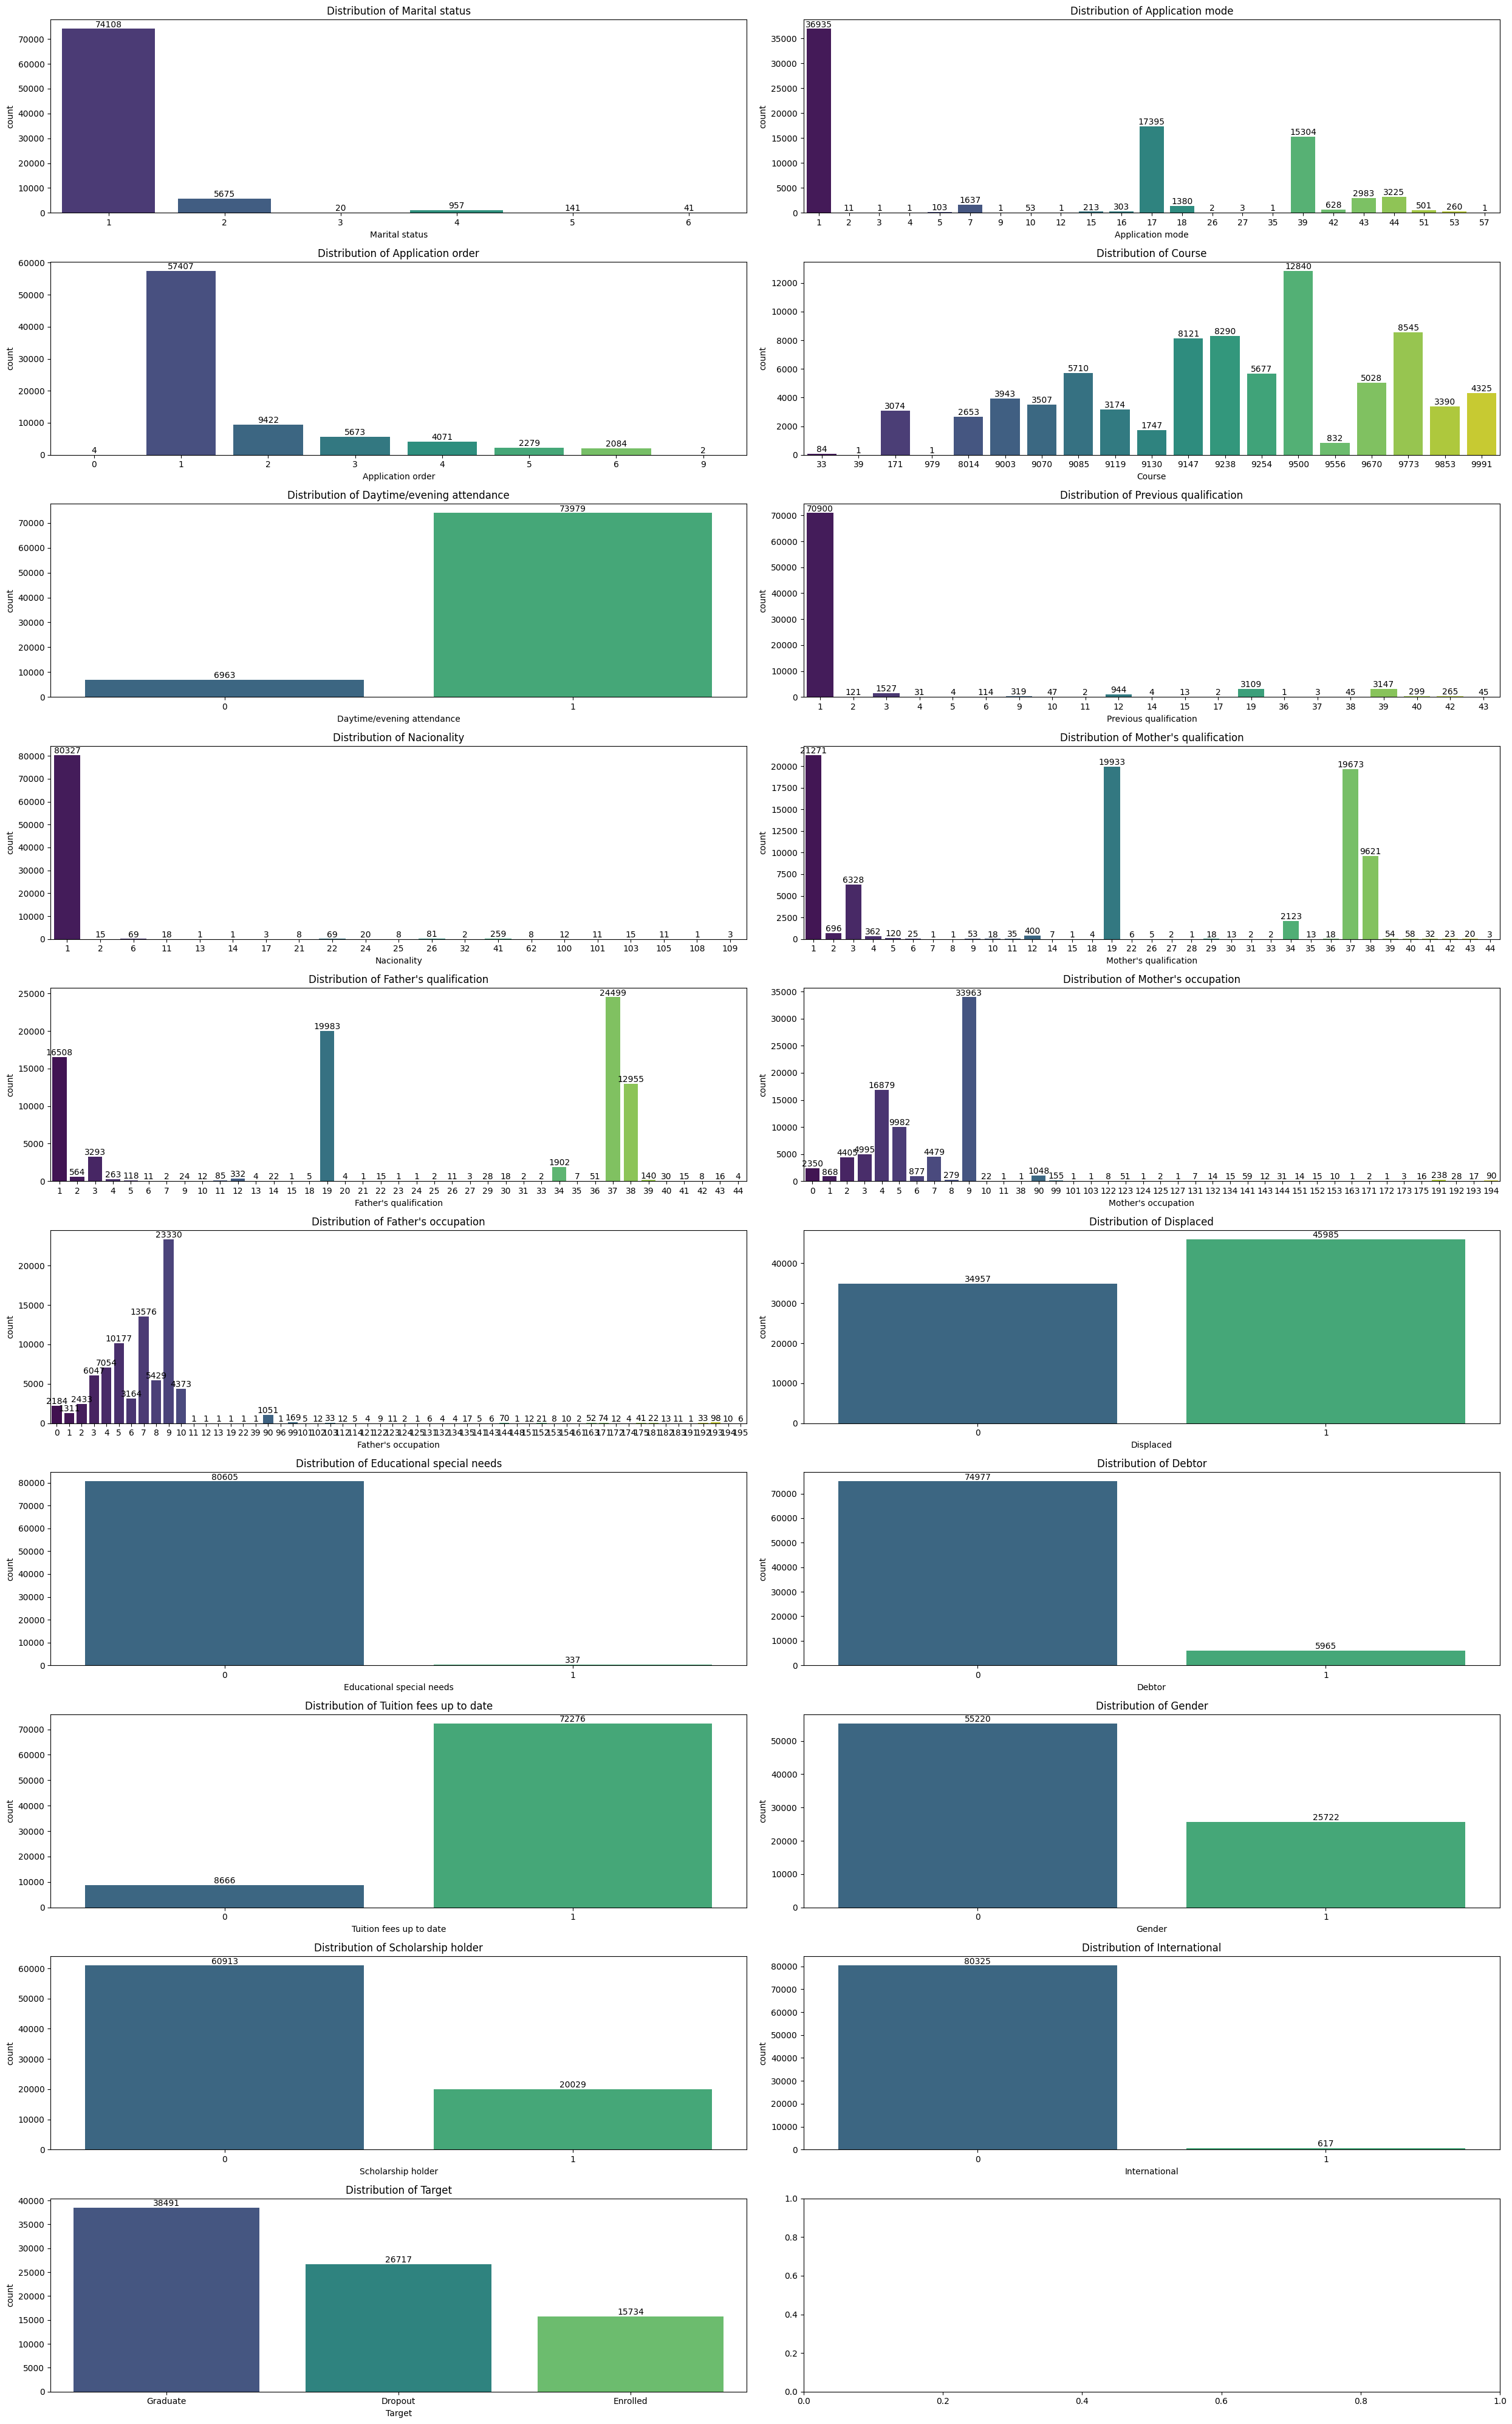

In [ ]:
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(10, 2, figsize=(25, 40))
axes = axes.flatten()

for i, col in enumerate(categorical_col):
    sns.countplot(x=col, data=data, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels())

    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=10, xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

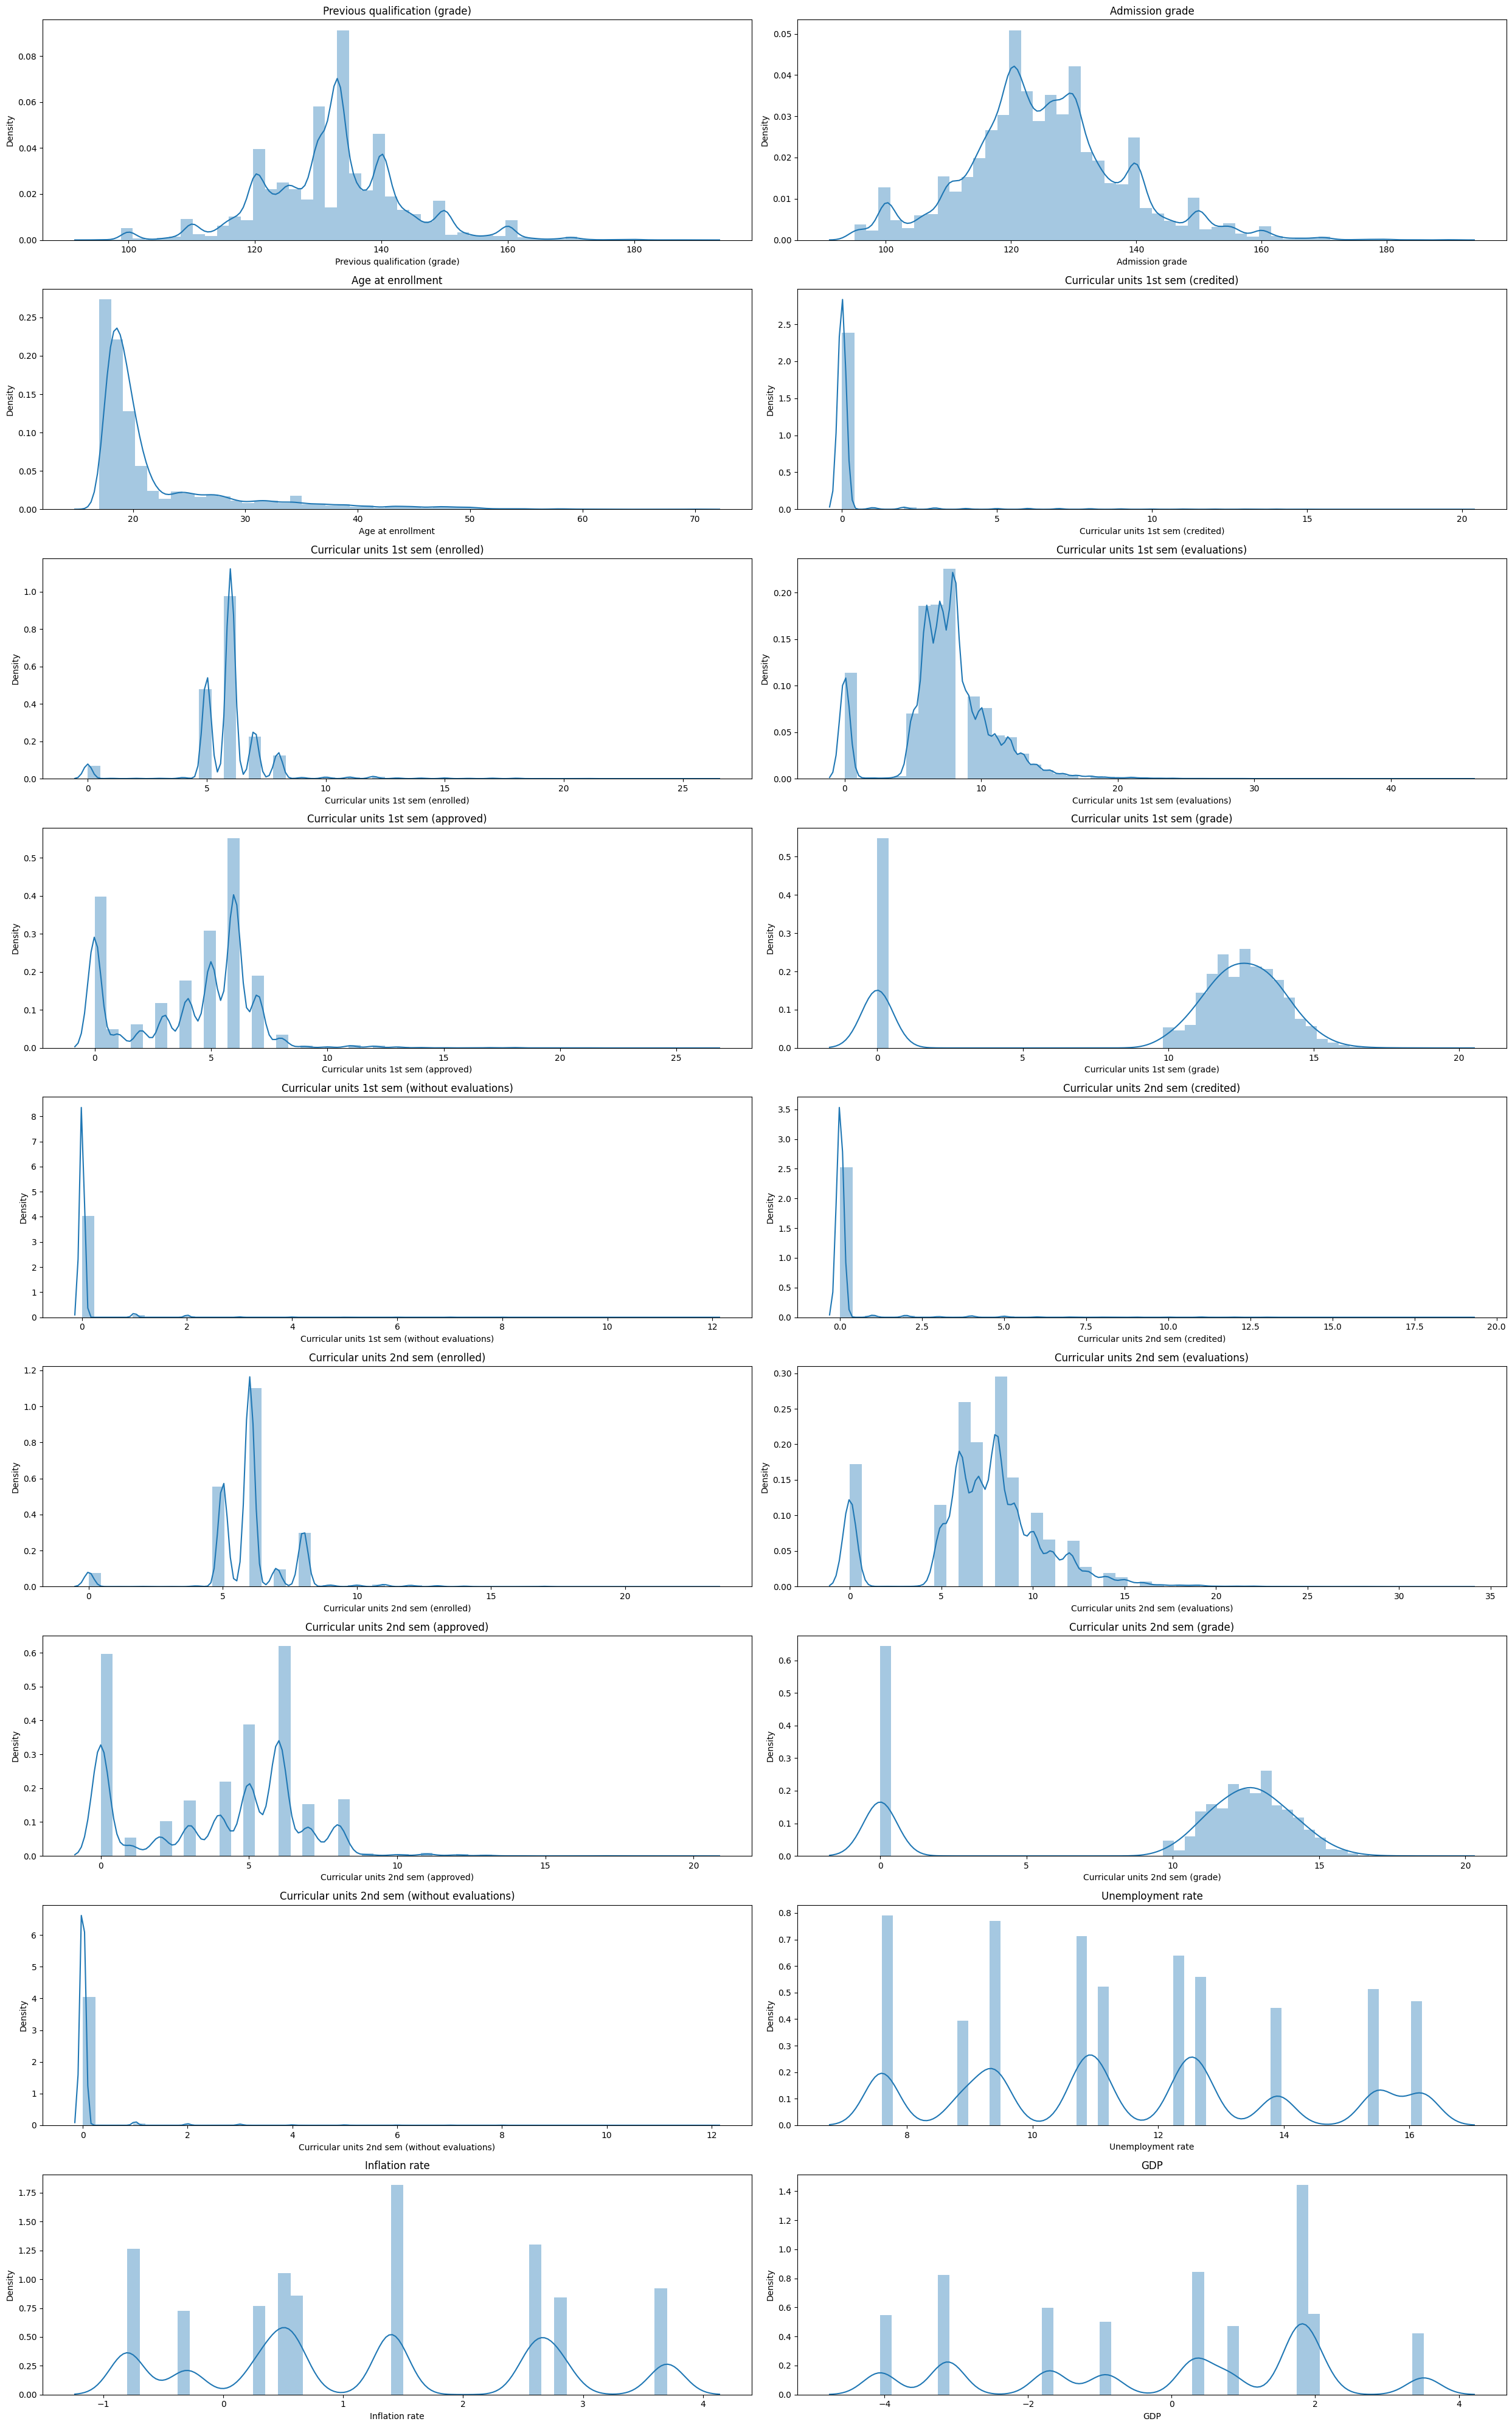

In [ ]:
# filter warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(9, 2, figsize=(25,40))

index = 0
axs = axs.flatten()
for index, col in enumerate(data[numerical_col]):
  sns.distplot(data[col], ax=axs[index])
  axs[index].set_title(col)

plt.tight_layout()
plt.show()

## bivariate Analysis

<Axes: >

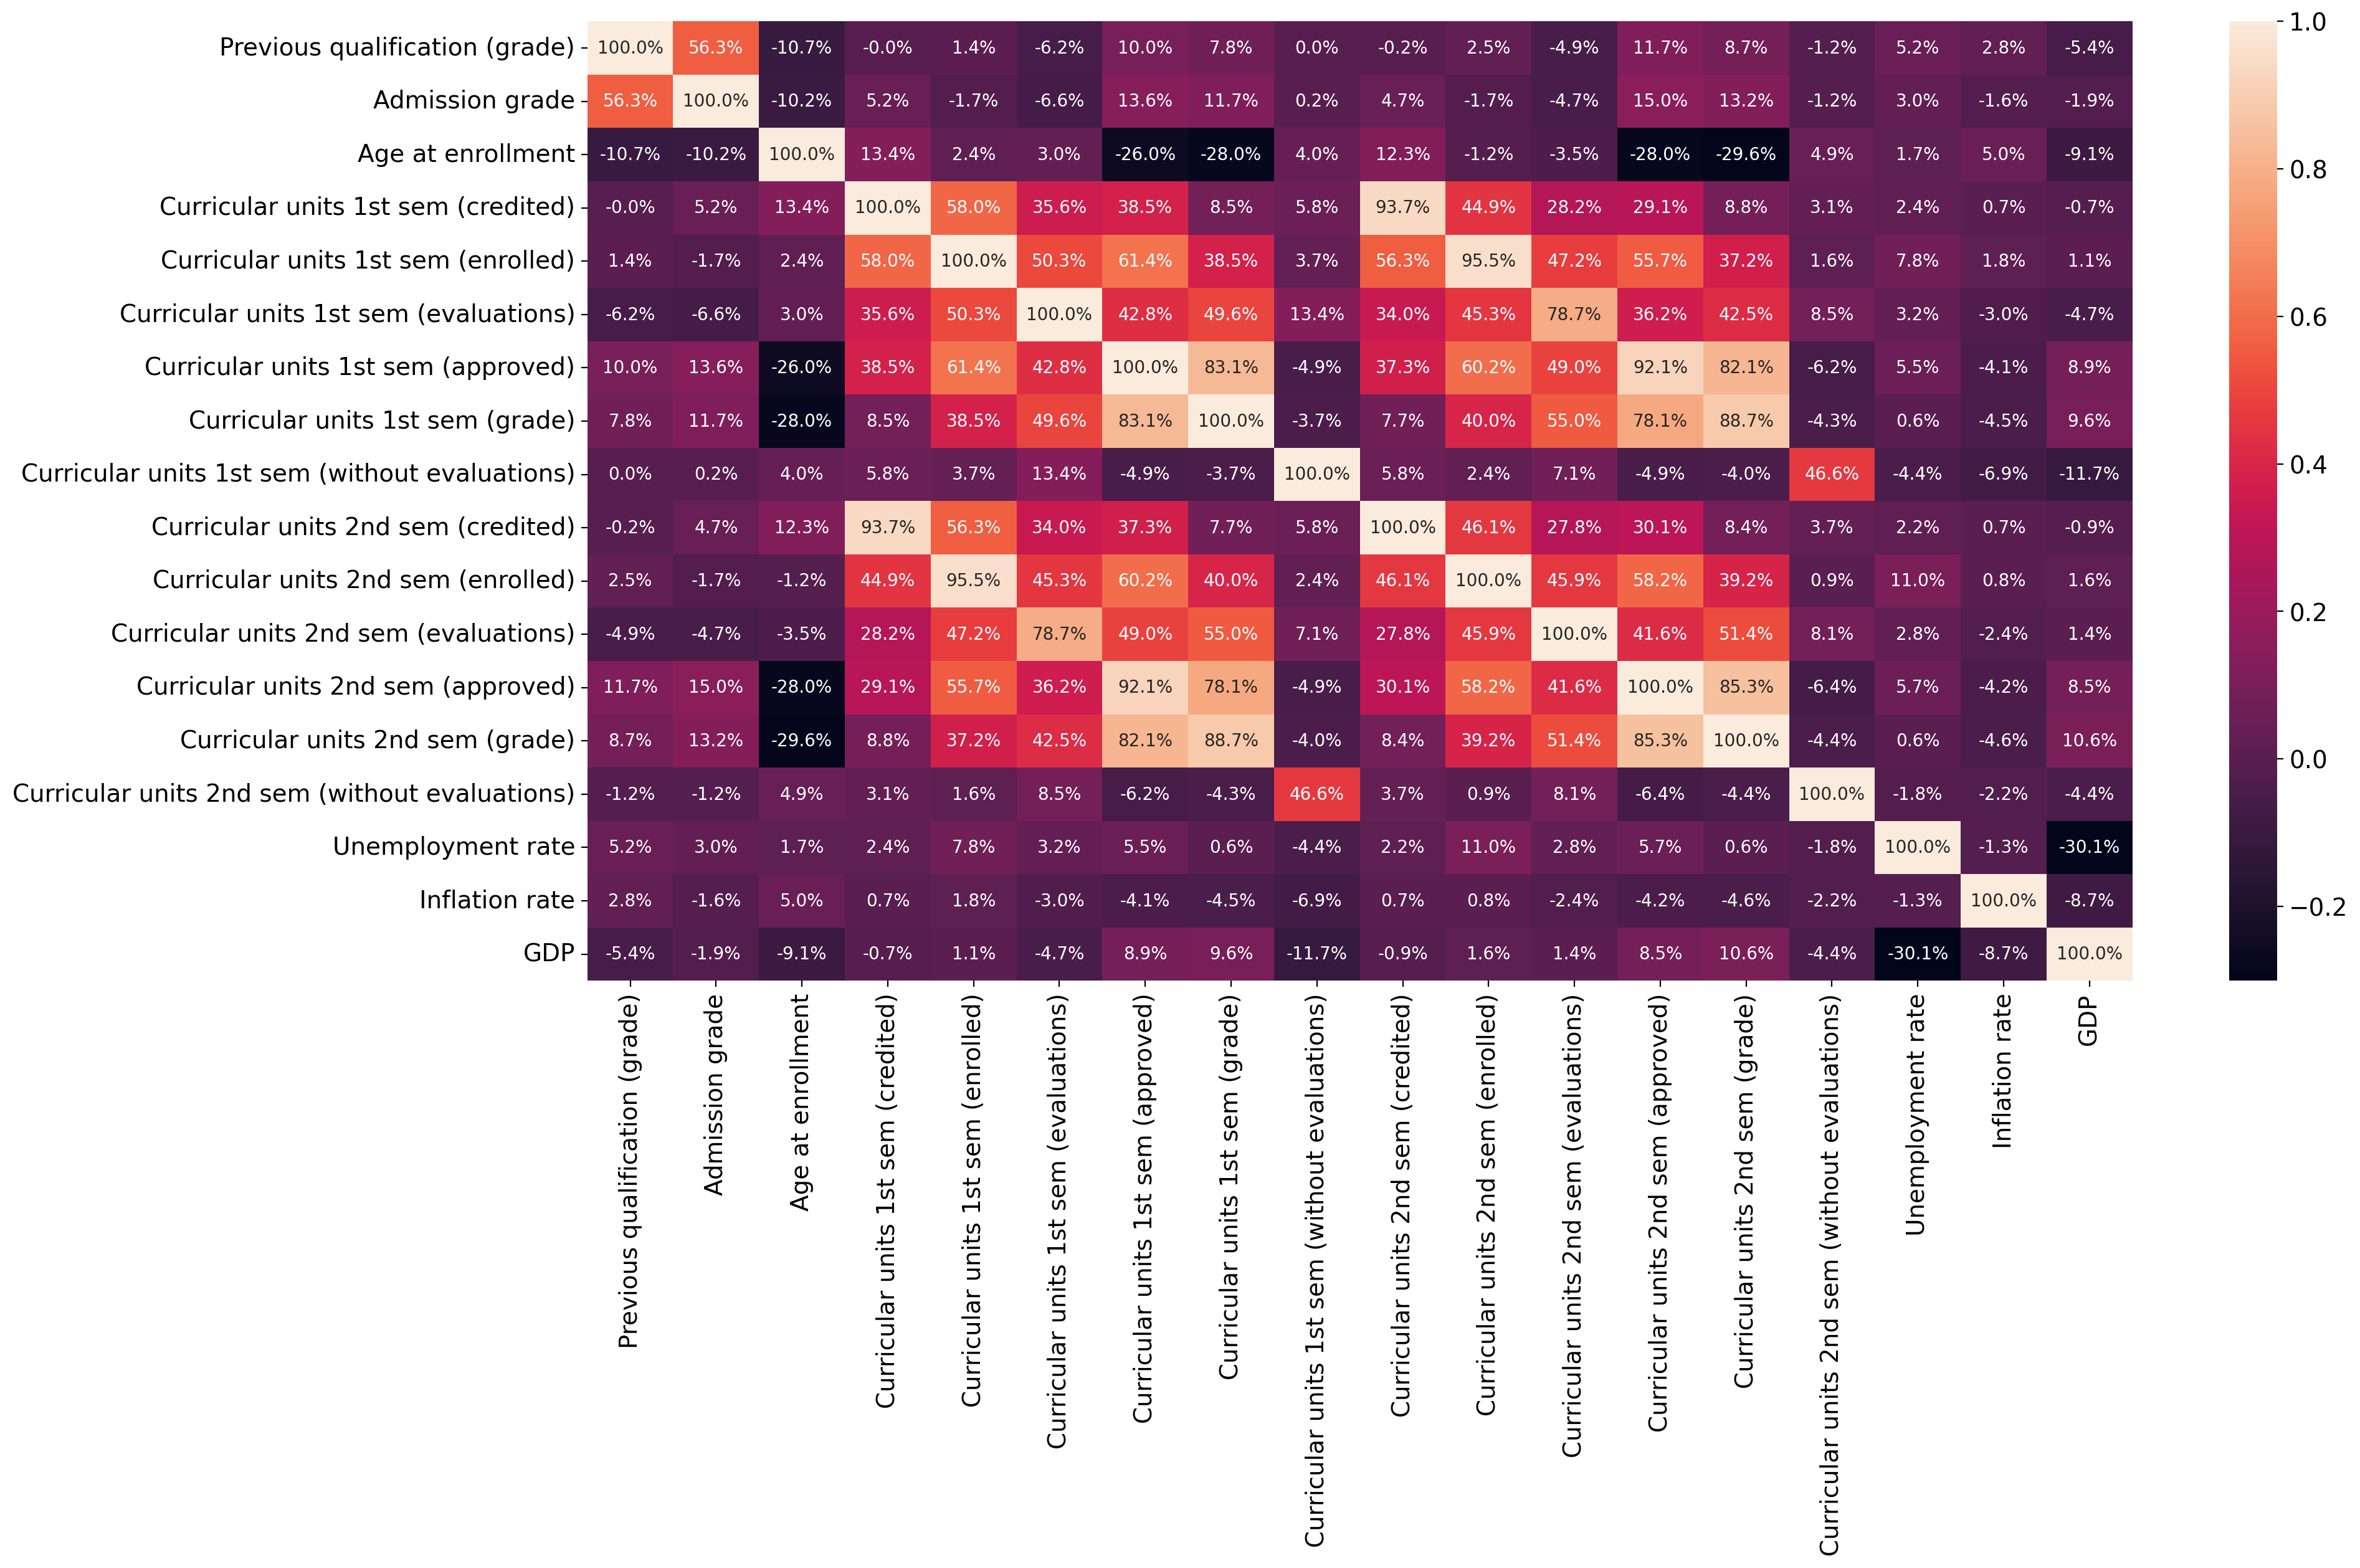

In [ ]:
corr_mat = data[numerical_col].corr()
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams['figure.dpi'] = 200
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.heatmap(corr_mat, annot=True, fmt=".1%")

# Preprocessing

## drop features with high corr

In [ ]:
# data = data.drop(columns=['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (approved)'])
# test = test.drop(columns=['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (approved)'])

## Checking the skewness

In [ ]:
numeric_data = data[numerical_col]
numeric_test = test[numerical_col]

# Calculate skewness of numerical features
skewness = numeric_data.apply(skew)
skewness_test = numeric_test.apply(skew)

print("Skewness of numerical features in train data:")
print(skewness)
print("\nSkewness of numerical features in test data:")
print(skewness_test)

Skewness of numerical features in train data:
Previous qualification (grade)                     0.231990
Admission grade                                    0.419690
Age at enrollment                                  2.350110
Curricular units 1st sem (credited)                7.710746
Curricular units 1st sem (enrolled)                0.549057
Curricular units 1st sem (evaluations)             0.185249
Curricular units 1st sem (approved)               -0.034020
Curricular units 1st sem (grade)                  -1.281178
Curricular units 1st sem (without evaluations)    11.341533
Curricular units 2nd sem (credited)                8.813673
Curricular units 2nd sem (enrolled)               -0.379189
Curricular units 2nd sem (evaluations)            -0.125524
Curricular units 2nd sem (approved)               -0.115990
Curricular units 2nd sem (grade)                  -1.078570
Curricular units 2nd sem (without evaluations)    10.149205
Unemployment rate                                  0.2

### right skw

In [ ]:
skewed_columns = ['Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)',
                  'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)']


for column in skewed_columns:
    data[f'{column}_sqrt'] = np.sqrt(data[column])
    data[f'{column}_log'] = np.log1p(data[column])

# Calculate skewness before and after transformations
skewness_before = data[skewed_columns].apply(skew)
skewness_after_sqrt = data[[f'{column}_sqrt' for column in skewed_columns]].apply(skew)
skewness_after_log = data[[f'{column}_log' for column in skewed_columns]].apply(skew)

# Print skewness before and after transformations
print("Skewness before transformation:")
print(skewness_before)
print("\nSkewness after square root transformation:")
print(skewness_after_sqrt)
print("\nSkewness after log transformation:")
print(skewness_after_log)

Skewness before transformation:
Age at enrollment                                  2.350110
Curricular units 1st sem (credited)                7.710746
Curricular units 1st sem (without evaluations)    11.341533
Curricular units 2nd sem (credited)                8.813673
Curricular units 2nd sem (without evaluations)    10.149205
dtype: float64

Skewness after square root transformation:
Age at enrollment_sqrt                                 2.030691
Curricular units 1st sem (credited)_sqrt               5.422396
Curricular units 1st sem (without evaluations)_sqrt    6.267682
Curricular units 2nd sem (credited)_sqrt               5.895239
Curricular units 2nd sem (without evaluations)_sqrt    6.665278
dtype: float64

Skewness after log transformation:
Age at enrollment_log                                 1.782402
Curricular units 1st sem (credited)_log               5.307241
Curricular units 1st sem (without evaluations)_log    6.574536
Curricular units 2nd sem (credited)_log          

In [ ]:
data = data.drop(['Age at enrollment', 'Age at enrollment_sqrt',
                  'Curricular units 1st sem (credited)', 'Curricular units 1st sem (credited)_sqrt',
                  'Curricular units 1st sem (without evaluations)', 'Curricular units 1st sem (without evaluations)_log',
                  'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (credited)_sqrt',
                  'Curricular units 2nd sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)_log'], axis=1)

In [ ]:
skewed_columns = ['Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)',
                  'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)']


for column in skewed_columns:
    test[f'{column}_sqrt'] = np.sqrt(test[column])
    test[f'{column}_log'] = np.log1p(test[column])

# Calculate skewness before and after transformations
skewness_before = test[skewed_columns].apply(skew)
skewness_after_sqrt = test[[f'{column}_sqrt' for column in skewed_columns]].apply(skew)
skewness_after_log = test[[f'{column}_log' for column in skewed_columns]].apply(skew)

# Print skewness before and after transformations
print("Skewness before transformation:")
print(skewness_before)
print("\nSkewness after square root transformation:")
print(skewness_after_sqrt)
print("\nSkewness after log transformation:")
print(skewness_after_log)

Skewness before transformation:
Age at enrollment                                  2.386957
Curricular units 1st sem (credited)                8.347156
Curricular units 1st sem (without evaluations)    11.362102
Curricular units 2nd sem (credited)                9.461228
Curricular units 2nd sem (without evaluations)    10.100937
dtype: float64

Skewness after square root transformation:
Age at enrollment_sqrt                                 2.059993
Curricular units 1st sem (credited)_sqrt               5.841777
Curricular units 1st sem (without evaluations)_sqrt    6.378896
Curricular units 2nd sem (credited)_sqrt               6.283328
Curricular units 2nd sem (without evaluations)_sqrt    6.818493
dtype: float64

Skewness after log transformation:
Age at enrollment_log                                 1.805836
Curricular units 1st sem (credited)_log               5.728819
Curricular units 1st sem (without evaluations)_log    6.686865
Curricular units 2nd sem (credited)_log          

In [ ]:
test = test.drop(['Age at enrollment', 'Age at enrollment_sqrt',
                  'Curricular units 1st sem (credited)', 'Curricular units 1st sem (credited)_sqrt',
                  'Curricular units 1st sem (without evaluations)', 'Curricular units 1st sem (without evaluations)_log',
                  'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (credited)_sqrt',
                  'Curricular units 2nd sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)_log'], axis=1)

### left skw

Curricular units 1st sem (grade) skewness before transformation: -1.2812021405774183
Curricular units 1st sem (grade) skewness after reflect_log transformation: -0.9934145215142783
Curricular units 1st sem (grade) skewness after boxcox transformation: -1.1209001197594772
Curricular units 1st sem (grade) skewness after yeojohnson transformation: -1.120900111654594


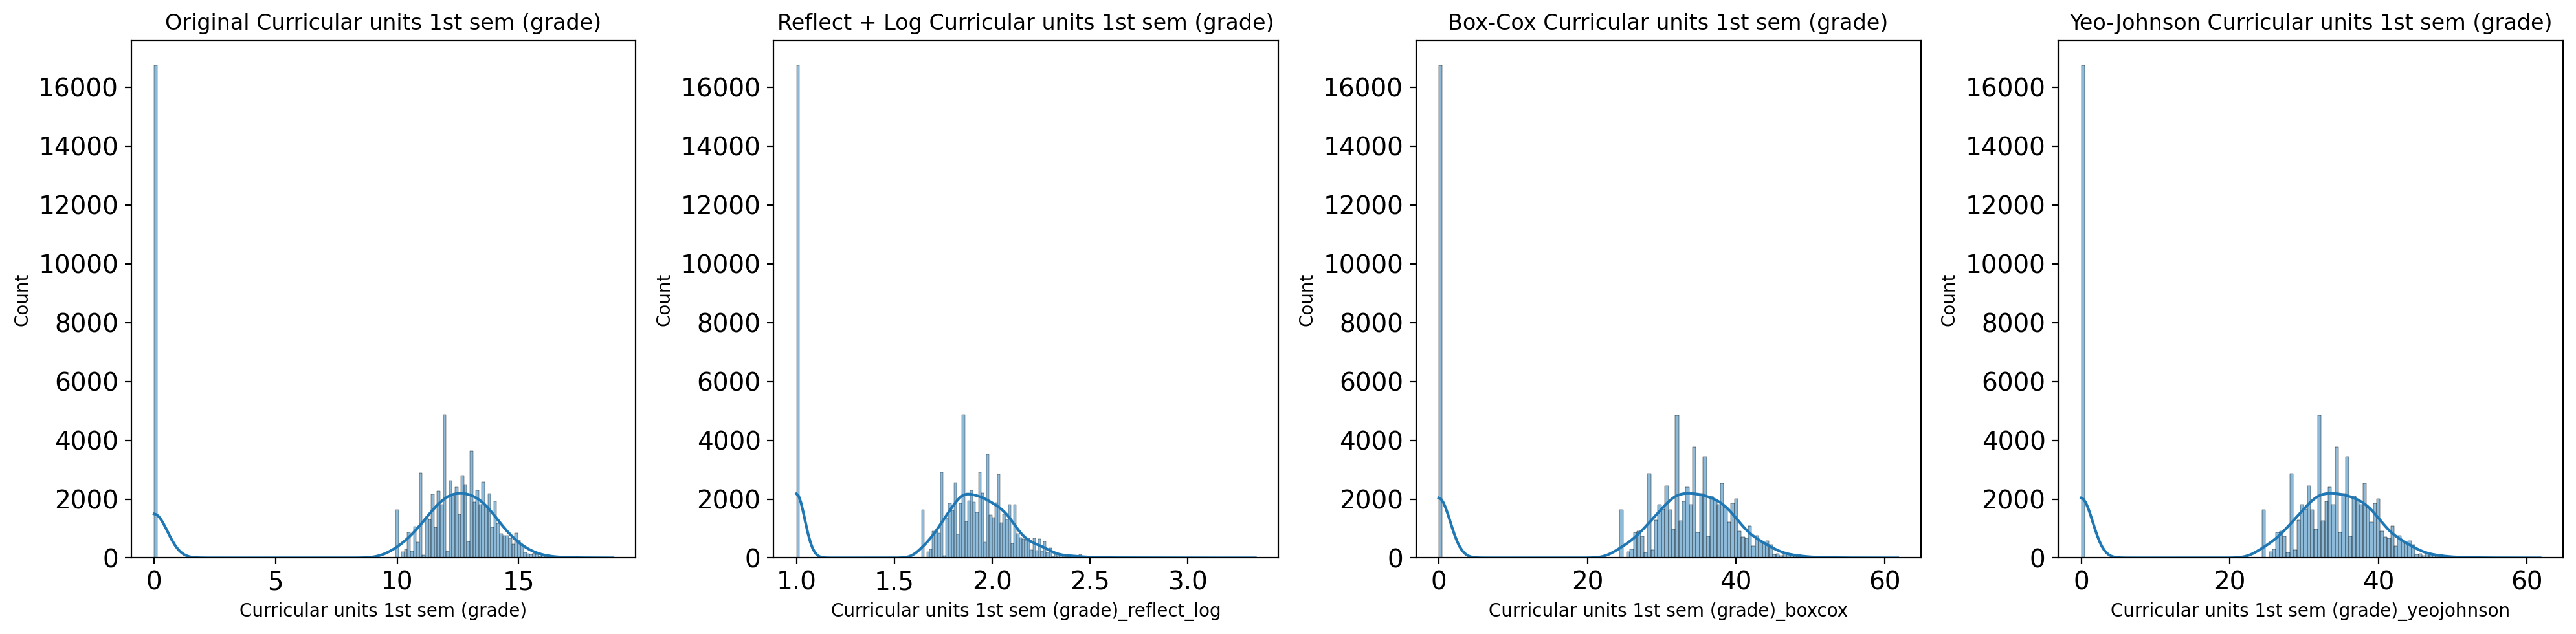

Curricular units 2nd sem (grade) skewness before transformation: -1.0785900511346467
Curricular units 2nd sem (grade) skewness after reflect_log transformation: -0.8072720813335448
Curricular units 2nd sem (grade) skewness after boxcox transformation: -1.0032616298712347
Curricular units 2nd sem (grade) skewness after yeojohnson transformation: -1.0032616244709207


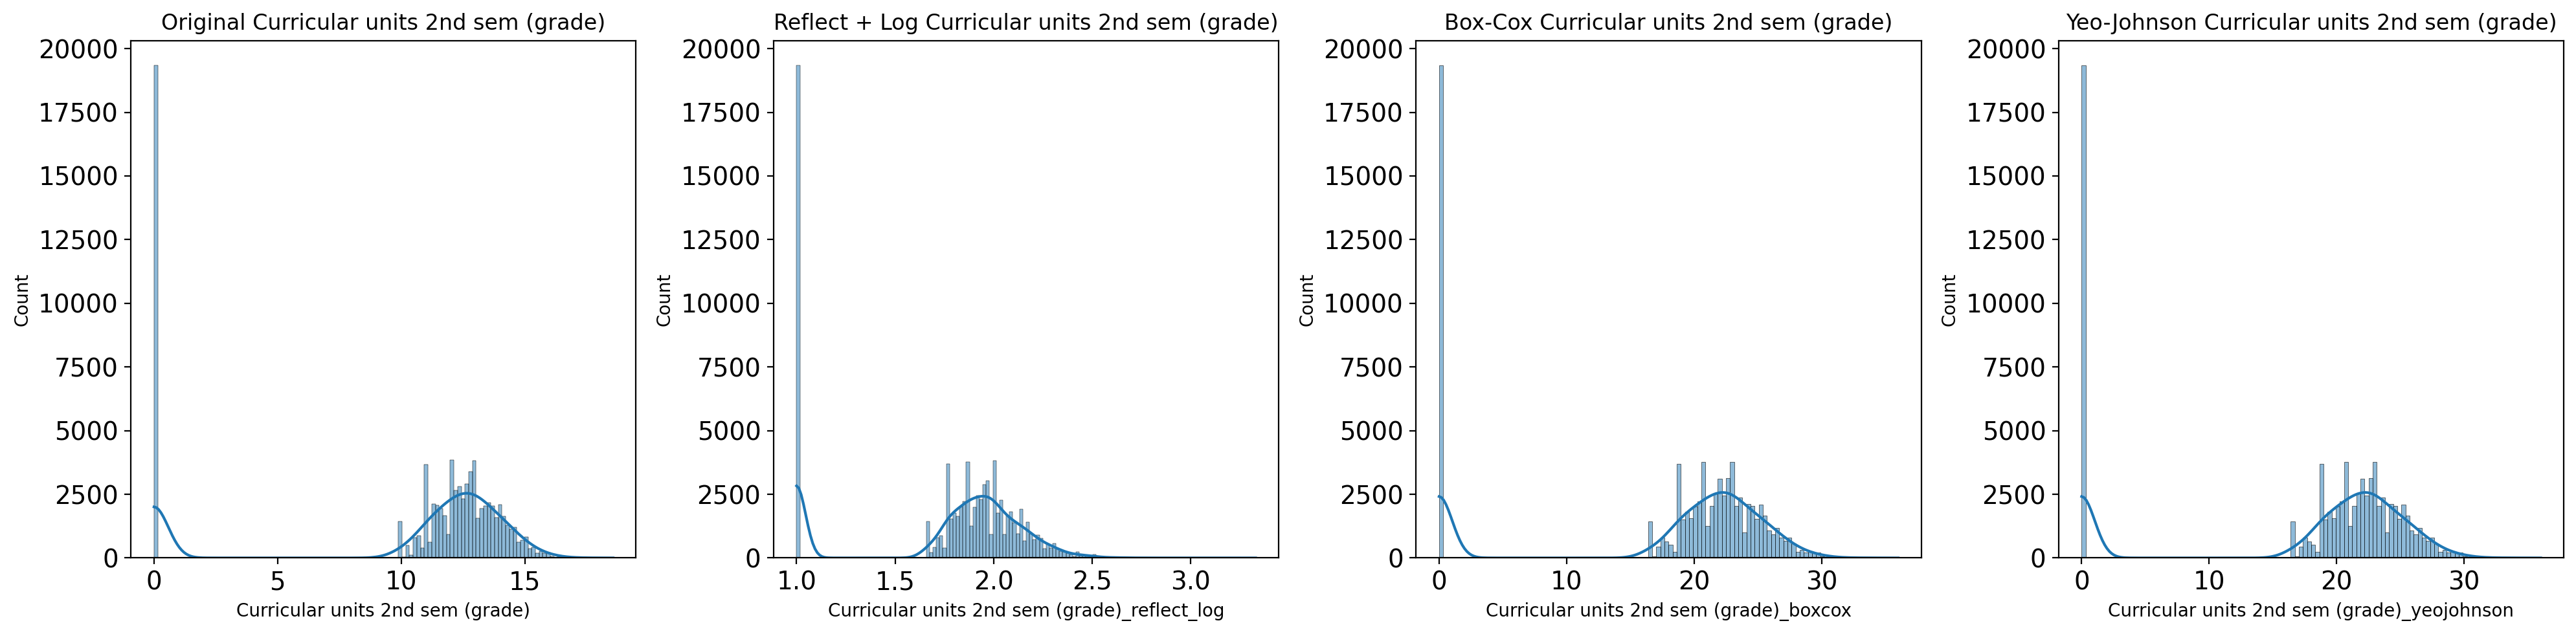

In [ ]:
# Function to apply reflection transformation
def reflect_and_transform(col, transform_func):
    reflected = max(col) + 1 - col
    transformed = transform_func(reflected)
    return max(transformed) + 1 - transformed

# Columns with left skewness
cols = ['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']

# Applying transformations and calculating skewness
for col in cols:
    original_skew = data[col].skew()

    data[f'{col}_reflect_log'] = reflect_and_transform(data[col], np.log1p)
    reflect_log_skew = data[f'{col}_reflect_log'].skew()

    data[f'{col}_boxcox'], _ = boxcox(data[col] + 1)  # Adding 1 to avoid issues with zero or negative values
    boxcox_skew = data[f'{col}_boxcox'].skew()

    data[f'{col}_yeojohnson'], _ = yeojohnson(data[col])
    yeojohnson_skew = data[f'{col}_yeojohnson'].skew()

    # Printing skewness
    print(f"{col} skewness before transformation: {original_skew}")
    print(f"{col} skewness after reflect_log transformation: {reflect_log_skew}")
    print(f"{col} skewness after boxcox transformation: {boxcox_skew}")
    print(f"{col} skewness after yeojohnson transformation: {yeojohnson_skew}")

    # Plotting the distributions
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    sns.histplot(data[col], kde=True, ax=axs[0])
    axs[0].set_title(f'Original {col}')
    sns.histplot(data[f'{col}_reflect_log'], kde=True, ax=axs[1])
    axs[1].set_title(f'Reflect + Log {col}')
    sns.histplot(data[f'{col}_boxcox'], kde=True, ax=axs[2])
    axs[2].set_title(f'Box-Cox {col}')
    sns.histplot(data[f'{col}_yeojohnson'], kde=True, ax=axs[3])
    axs[3].set_title(f'Yeo-Johnson {col}')

    plt.tight_layout()
    plt.show()


In [ ]:
data = data.drop(['Curricular units 1st sem (grade)', 'Curricular units 1st sem (grade)_boxcox', 'Curricular units 1st sem (grade)_yeojohnson',
                  'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (grade)_boxcox', 'Curricular units 2nd sem (grade)_yeojohnson'], axis=1)

Curricular units 1st sem (grade) skewness before transformation: -1.306368939056033
Curricular units 1st sem (grade) skewness after reflect_log transformation: -1.008658044167741
Curricular units 1st sem (grade) skewness after boxcox transformation: -1.1327419497248288
Curricular units 1st sem (grade) skewness after yeojohnson transformation: -1.1327419497248283


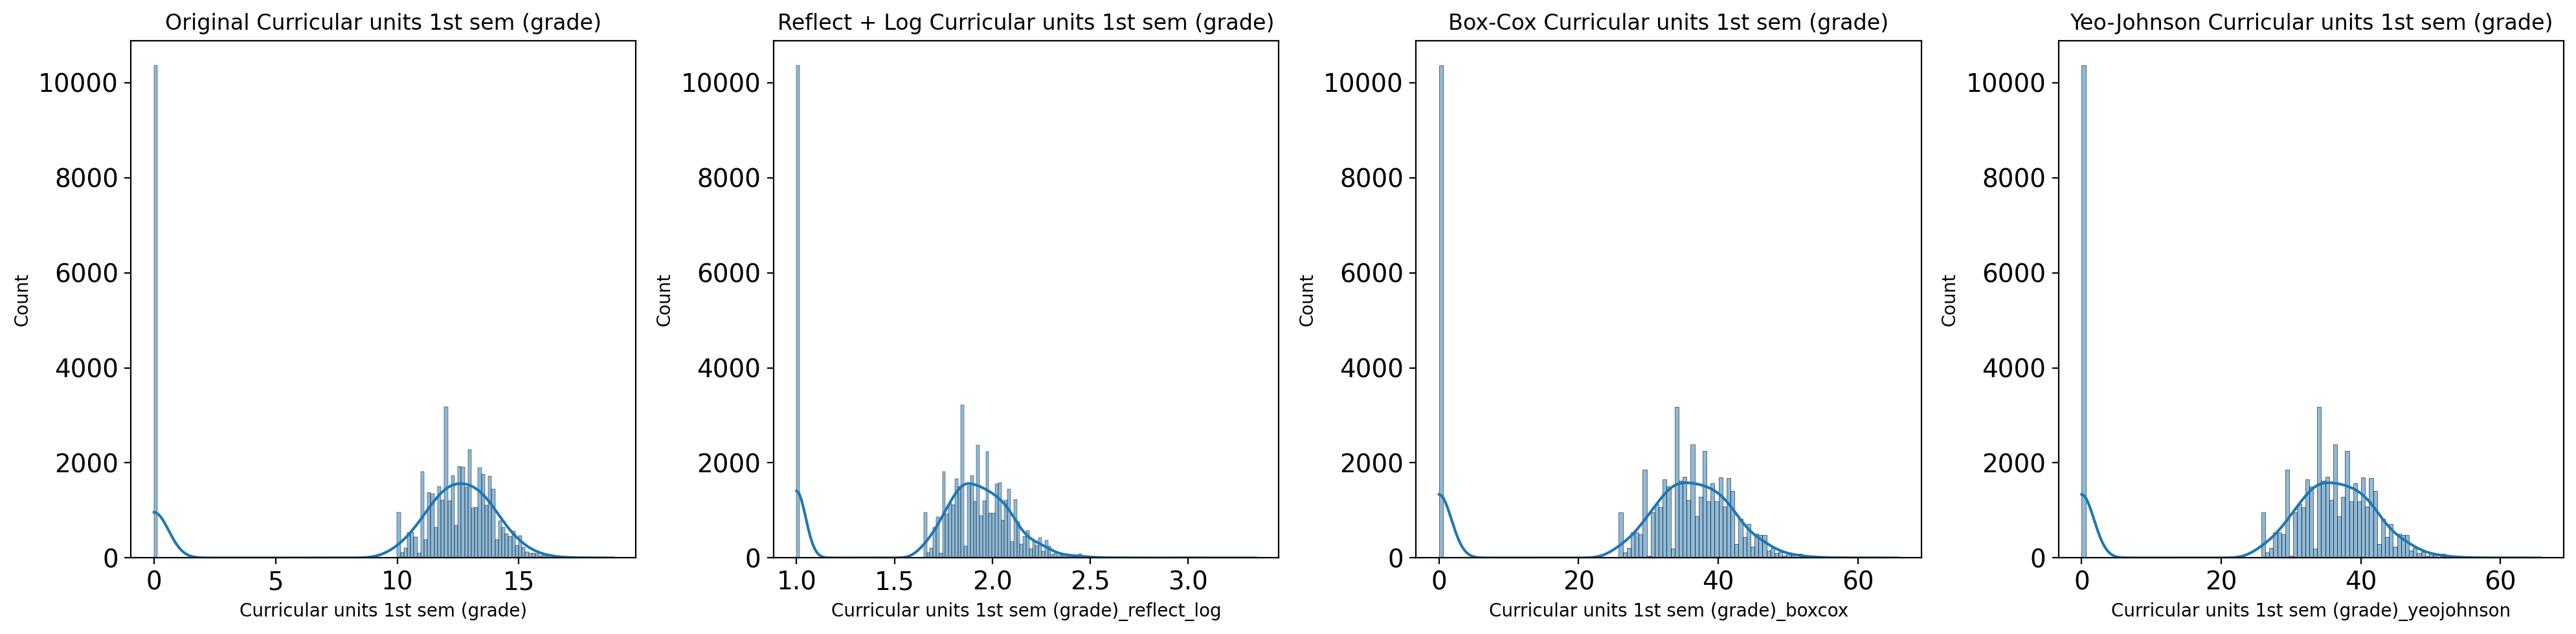

Curricular units 2nd sem (grade) skewness before transformation: -1.1031044225826916
Curricular units 2nd sem (grade) skewness after reflect_log transformation: -0.7839568001169517
Curricular units 2nd sem (grade) skewness after boxcox transformation: -1.01886046481577
Curricular units 2nd sem (grade) skewness after yeojohnson transformation: -1.01886046481577


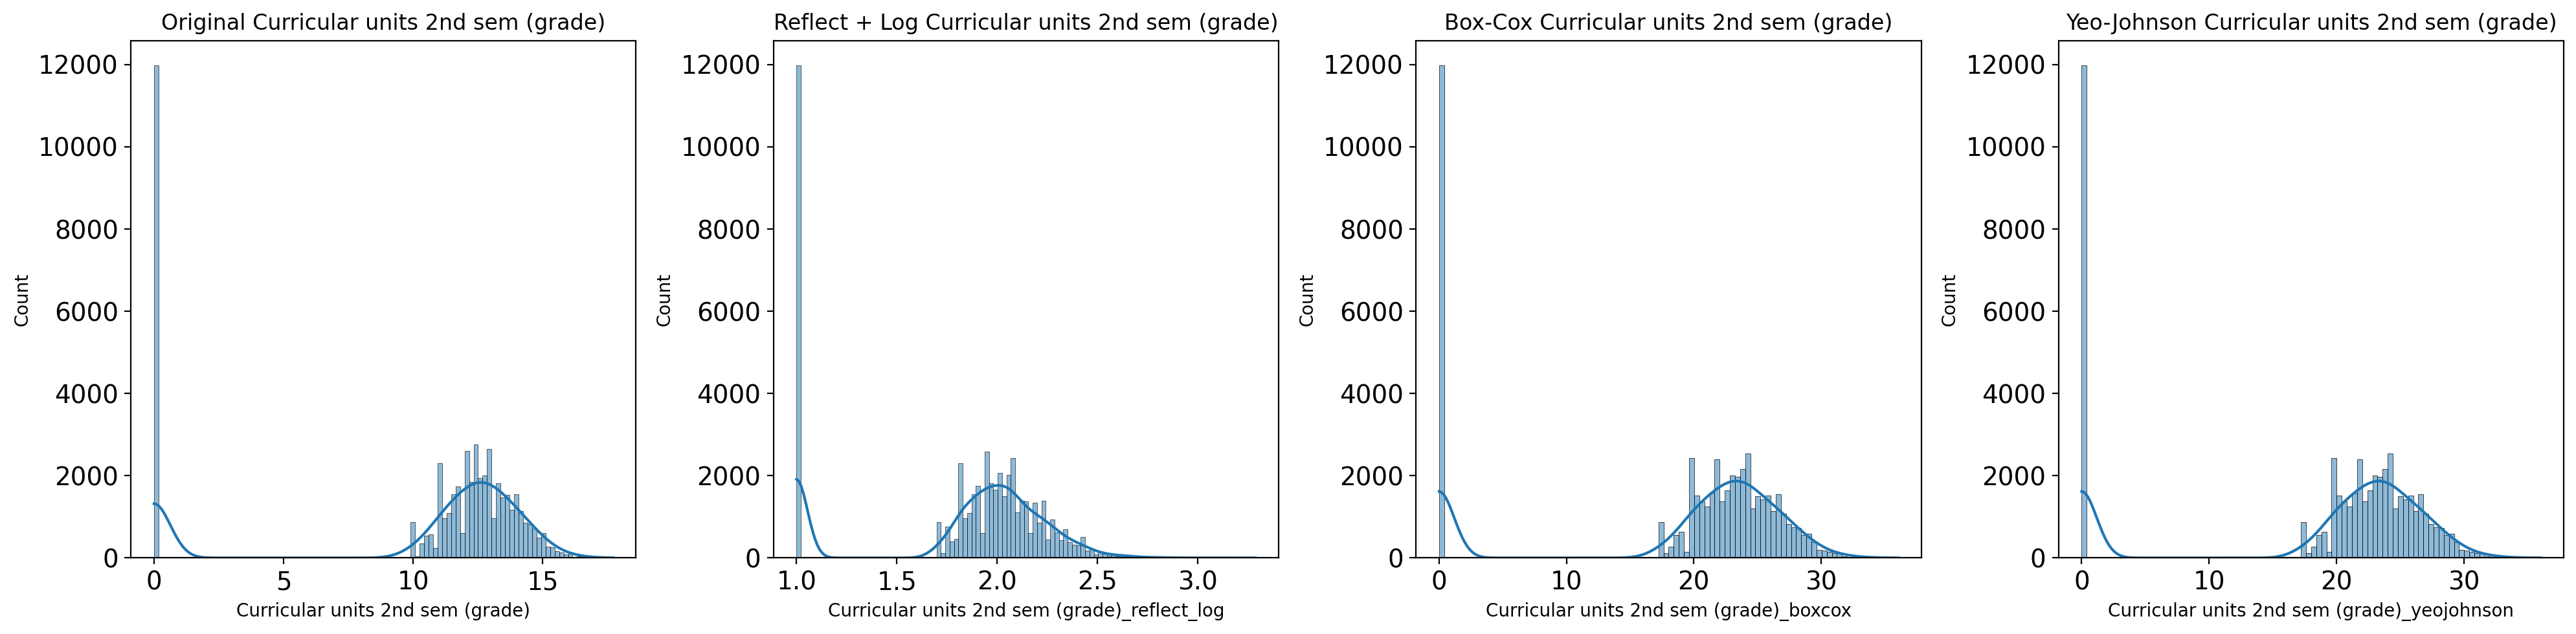

In [ ]:
# Columns with left skewness
cols = ['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']

# Applying transformations and calculating skewness
for col in cols:
    original_skew = test[col].skew()

    test[f'{col}_reflect_log'] = reflect_and_transform(test[col], np.log1p)
    reflect_log_skew = test[f'{col}_reflect_log'].skew()

    test[f'{col}_boxcox'], _ = boxcox(test[col] + 1)  # Adding 1 to avoid issues with zero or negative values
    boxcox_skew = test[f'{col}_boxcox'].skew()

    test[f'{col}_yeojohnson'], _ = yeojohnson(test[col])
    yeojohnson_skew = test[f'{col}_yeojohnson'].skew()

    # Printing skewness
    print(f"{col} skewness before transformation: {original_skew}")
    print(f"{col} skewness after reflect_log transformation: {reflect_log_skew}")
    print(f"{col} skewness after boxcox transformation: {boxcox_skew}")
    print(f"{col} skewness after yeojohnson transformation: {yeojohnson_skew}")

    # Plotting the distributions
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    sns.histplot(test[col], kde=True, ax=axs[0])
    axs[0].set_title(f'Original {col}')
    sns.histplot(test[f'{col}_reflect_log'], kde=True, ax=axs[1])
    axs[1].set_title(f'Reflect + Log {col}')
    sns.histplot(test[f'{col}_boxcox'], kde=True, ax=axs[2])
    axs[2].set_title(f'Box-Cox {col}')
    sns.histplot(test[f'{col}_yeojohnson'], kde=True, ax=axs[3])
    axs[3].set_title(f'Yeo-Johnson {col}')

    plt.tight_layout()
    plt.show()

In [ ]:
test = test.drop(['Curricular units 1st sem (grade)', 'Curricular units 1st sem (grade)_boxcox', 'Curricular units 1st sem (grade)_yeojohnson',
                  'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (grade)_boxcox', 'Curricular units 2nd sem (grade)_yeojohnson'], axis=1)

## Label Encoding

In [ ]:
# Map categorical values in target column to numerical labels
target_mapping = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}
data['Target'] = data['Target'].map(target_mapping)

In [ ]:
# Convert 'Course' column to string type
data['Course'] = data['Course'].astype(str)
test['Course'] = test['Course'].astype(str)

# Find unique course codes in train and test data
unique_train_courses = set(data['Course'].unique())
unique_test_courses = set(test['Course'].unique())

# Determine the course codes in test data that are not in train data
unseen_courses = unique_test_courses - unique_train_courses

print("Unseen course codes in test data:", unseen_courses)

Unseen course codes in test data: {'7500', '4147', '9257', '2105'}


In [ ]:
# Fit LabelEncoder on 'data' dataset
label_encoder = LabelEncoder()
data['Course'] = label_encoder.fit_transform(data['Course'])

In [ ]:
placeholder = -1

def encode_with_placeholder(encoder, series, placeholder):
    encoded = series.map(lambda s: encoder.transform([s])[0] if s in encoder.classes_ else placeholder)
    return encoded

test['Course'] = encode_with_placeholder(label_encoder, test['Course'], placeholder)

In [ ]:
test['Course'] = test['Course'].replace(placeholder, test['Course'].mode()[0])

## Train Test Split

In [ ]:
X = data.drop(['Target'], axis=1)
y = data.loc[:, 'Target'].values

In [ ]:
# Split Data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape (X, y):", X_train.shape, y_train.shape)
print("Testing set shape (X, y):", X_test.shape, y_test.shape)

Training set shape (X, y): (64753, 36) (64753,)
Testing set shape (X, y): (16189, 36) (16189,)


## Outlier detection

In [ ]:
# outlier data
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [ ]:
# outliers in train data
numerical_columns = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment_log',
                 'Curricular units 1st sem (credited)_log', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
                 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)_reflect_log', 'Curricular units 1st sem (without evaluations)_sqrt',
                 'Curricular units 2nd sem (credited)_log', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)',
                 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)_reflect_log', 'Curricular units 2nd sem (without evaluations)_sqrt',
                 'Unemployment rate', 'Inflation rate', 'GDP']

outlier_detection = data[numerical_columns]

for k, v in outlier_detection.items():
        outliers = find_outliers_IQR(v)
        perc = len(find_outliers_IQR(v)) * 100.0 / np.shape(outlier_detection)[0]
        print(f'Column :{k}')
        print(f"Number of Outliers = {len(outliers)}","||",f"Max Outlier Value = {outliers.max()}",
              "||", f"Min Outlier Value = {outliers.min()}", "||", f"Percentage of Outliers = {perc:.2f}%")
        print("\n")

Column :Previous qualification (grade)
Number of Outliers = 1543 || Max Outlier Value = 190.0 || Min Outlier Value = 95.0 || Percentage of Outliers = 1.91%


Column :Admission grade
Number of Outliers = 2800 || Max Outlier Value = 190.0 || Min Outlier Value = 95.0 || Percentage of Outliers = 3.46%


Column :Age at enrollment_log
Number of Outliers = 7026 || Max Outlier Value = 4.2626798770413155 || Min Outlier Value = 3.5553480614894135 || Percentage of Outliers = 8.68%


Column :Curricular units 1st sem (credited)_log
Number of Outliers = 3666 || Max Outlier Value = 3.044522437723423 || Min Outlier Value = 0.6931471805599453 || Percentage of Outliers = 4.53%


Column :Curricular units 1st sem (enrolled)
Number of Outliers = 9962 || Max Outlier Value = 26 || Min Outlier Value = 0 || Percentage of Outliers = 12.31%


Column :Curricular units 1st sem (evaluations)
Number of Outliers = 11427 || Max Outlier Value = 45 || Min Outlier Value = 0 || Percentage of Outliers = 14.12%


Column :Cu

In [ ]:
outlier_detection_test = test[numerical_columns]

for k, v in outlier_detection_test.items():
        outliers = find_outliers_IQR(v)
        perc = len(find_outliers_IQR(v)) * 100.0 / np.shape(outlier_detection_test)[0]
        print(f'Column :{k}')
        print(f"Number of Outliers = {len(outliers)}","||",f"Max Outlier Value = {outliers.max()}",
              "||", f"Min Outlier Value = {outliers.min()}", "||", f"Percentage of Outliers = {perc:.2f}%")
        print("\n")

Column :Previous qualification (grade)
Number of Outliers = 1009 || Max Outlier Value = 190.0 || Min Outlier Value = 95.0 || Percentage of Outliers = 1.98%


Column :Admission grade
Number of Outliers = 1724 || Max Outlier Value = 190.0 || Min Outlier Value = 95.0 || Percentage of Outliers = 3.38%


Column :Age at enrollment_log
Number of Outliers = 4130 || Max Outlier Value = 4.2626798770413155 || Min Outlier Value = 3.5553480614894135 || Percentage of Outliers = 8.10%


Column :Curricular units 1st sem (credited)_log
Number of Outliers = 1998 || Max Outlier Value = 3.044522437723423 || Min Outlier Value = 0.6931471805599453 || Percentage of Outliers = 3.92%


Column :Curricular units 1st sem (enrolled)
Number of Outliers = 6000 || Max Outlier Value = 23 || Min Outlier Value = 0 || Percentage of Outliers = 11.76%


Column :Curricular units 1st sem (evaluations)
Number of Outliers = 6923 || Max Outlier Value = 45 || Min Outlier Value = 0 || Percentage of Outliers = 13.57%


Column :Cur

In [ ]:
# Anomaly Detection
'''
# First method: Isolation Forests
ifor = IsolationForest(random_state=42,
                       contamination=0.05, warm_start=True)
y_train_pred = ifor.fit_predict(X_train)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train, y_train = X_train[mask], y_train[mask]
#--------------------------------------------------------------

# Second method: Local Outlier Factor
LOF = LocalOutlierFactor(n_neighbors=20, contamination='auto')
y_train_pred = LOF.fit_predict(X_train)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train, y_train = X_train[mask], y_train[mask]
#--------------------------------------------------------------

# third method: Elliptic
EE = EllipticEnvelope(contamination=0.1, random_state=42)
y_train_pred = EE.fit_predict(X_train)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train, y_train = X_train[mask], y_train[mask]
#--------------------------------------------------------------

# fourth method: One Class Support Vector Machine
ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
y_train_pred = ocsvm.fit_predict(X_train)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train, y_train = X_train[mask], y_train[mask]
'''

"\n# First method: Isolation Forests\nifor = IsolationForest(random_state=42,\n                       contamination=0.05, warm_start=True)\ny_train_pred = ifor.fit_predict(X_train)\n\n# removing outliers(select only the normal data)\nmask =y_train_pred !=-1\nX_train, y_train = X_train[mask], y_train[mask]\n#--------------------------------------------------------------\n\n# Second method: Local Outlier Factor\nLOF = LocalOutlierFactor(n_neighbors=20, contamination='auto')\ny_train_pred = LOF.fit_predict(X_train)\n\n# removing outliers(select only the normal data)\nmask =y_train_pred !=-1\nX_train, y_train = X_train[mask], y_train[mask]\n#--------------------------------------------------------------\n\n# third method: Elliptic\nEE = EllipticEnvelope(contamination=0.1, random_state=42)\ny_train_pred = EE.fit_predict(X_train)\n\n# removing outliers(select only the normal data)\nmask =y_train_pred !=-1\nX_train, y_train = X_train[mask], y_train[mask]\n#------------------------------------

In [ ]:
'''
def handle_outliers(X_train, X_test, test, columns):
    for col in columns:
        Q1 = np.percentile(X_train[col], 25)
        Q3 = np.percentile(X_train[col], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Handling outliers in X_train
        X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])
        X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])

        # Handling outliers in X_test based on X_train IQR
        X_test[col] = np.where(X_test[col] < lower_bound, lower_bound, X_test[col])
        X_test[col] = np.where(X_test[col] > upper_bound, upper_bound, X_test[col])

        # Handling outliers in test dataset based on X_train IQR
        test[col] = np.where(test[col] < lower_bound, lower_bound, test[col])
        test[col] = np.where(test[col] > upper_bound, upper_bound, test[col])

    return X_train, X_test, , test


# Define the columns to apply outlier handling
columns_to_handle = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment_log', 'Curricular units 1st sem (credited)_log',
                  'Curricular units 1st sem (grade)_reflect_log', 'Curricular units 1st sem (without evaluations)_sqrt', 'Curricular units 2nd sem (credited)_log',
                  'Curricular units 2nd sem (grade)_reflect_log', 'Curricular units 2nd sem (without evaluations)_sqrt']
# Apply the function to the specified columns
X_train, X_test, test = handle_outliers(X_train, X_test, test, columns_to_handle)
'''


"\ndef handle_outliers(X_train, X_test, test, columns):\n    for col in columns:\n        Q1 = np.percentile(X_train[col], 25)\n        Q3 = np.percentile(X_train[col], 75)\n        IQR = Q3 - Q1\n        lower_bound = Q1 - 1.5 * IQR\n        upper_bound = Q3 + 1.5 * IQR\n\n        # Handling outliers in X_train\n        X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])\n        X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])\n\n        # Handling outliers in X_test based on X_train IQR\n        X_test[col] = np.where(X_test[col] < lower_bound, lower_bound, X_test[col])\n        X_test[col] = np.where(X_test[col] > upper_bound, upper_bound, X_test[col])\n\n        # Handling outliers in test dataset based on X_train IQR\n        test[col] = np.where(test[col] < lower_bound, lower_bound, test[col])\n        test[col] = np.where(test[col] > upper_bound, upper_bound, test[col])\n\n    return X_train, X_test, , test\n\n\n# Define 

In [ ]:
'''
def handle_outliers_2(X_train, X_test, test, columns):
    for col in columns:
        Q1 = np.percentile(X_train[col], 25)
        Q3 = np.percentile(X_train[col], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1 * IQR
        upper_bound = Q3 + 1 * IQR

        # Handling outliers in X_train
        X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])
        X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])

        # Handling outliers in X_test based on X_train IQR
        X_test[col] = np.where(X_test[col] < lower_bound, lower_bound, X_test[col])
        X_test[col] = np.where(X_test[col] > upper_bound, upper_bound, X_test[col])

        # Handling outliers in test dataset based on X_train IQR
        test[col] = np.where(test[col] < lower_bound, lower_bound, test[col])
        test[col] = np.where(test[col] > upper_bound, upper_bound, test[col])

    return X_train, X_test, test


# Define the columns to apply outlier handling
columns_to_handle = ['Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)'
                    'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)']
# Apply the function to the specified columns
X_train, X_test, test = handle_outliers_2(X_train, X_test, test, columns_to_handle)
'''

"\ndef handle_outliers_2(X_train, X_test, test, columns):\n    for col in columns:\n        Q1 = np.percentile(X_train[col], 25)\n        Q3 = np.percentile(X_train[col], 75)\n        IQR = Q3 - Q1\n        lower_bound = Q1 - 1 * IQR\n        upper_bound = Q3 + 1 * IQR\n\n        # Handling outliers in X_train\n        X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])\n        X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])\n\n        # Handling outliers in X_test based on X_train IQR\n        X_test[col] = np.where(X_test[col] < lower_bound, lower_bound, X_test[col])\n        X_test[col] = np.where(X_test[col] > upper_bound, upper_bound, X_test[col])\n\n        # Handling outliers in test dataset based on X_train IQR\n        test[col] = np.where(test[col] < lower_bound, lower_bound, test[col])\n        test[col] = np.where(test[col] > upper_bound, upper_bound, test[col])\n\n    return X_train, X_test, test\n\n\n# Define the 

## Scaling

In [ ]:
'''
# first method
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test = scaler.transform(test)
'''

# Second method
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test = scaler.transform(test)

## Handling Imbalanced lable

In [ ]:
# Count the values of y_train
y_train_counts = pd.Series(y_train).value_counts()

print("Counts of each class in y_train:")
print(y_train_counts)

Counts of each class in y_train:
0    30775
1    21383
2    12595
Name: count, dtype: int64


In [ ]:
# SMOTETomek

# Apply SMOTETomek to the training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print('Resampled training set shape:\n', pd.Series(y_train_resampled).value_counts())

Resampled training set shape:
 2    30015
1    29990
0    29622
Name: count, dtype: int64


# Modeling

## Evaluation Function

In [ ]:
def train_and_evaluate(model_class, best_params, X_train, y_train, X_test, y_test):
    # Initialize and train the model
    model = model_class(**best_params)
    model.fit(X_train, y_train)

    # Predict on train and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate metrics
    train_score = model.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    test_f1_micro = f1_score(y_test, y_test_pred, average='micro')
    test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)

    # Print results
    print(f"Model: {model_class.__name__}")
    print("-" * 30)
    print(f"Train Score: {train_score:.5f}")
    print("-" * 30)
    print(f"Test Accuracy: {test_accuracy:.5f}")
    print("-" * 30)
    print(f"Test Precision (macro): {test_precision:.5f}")
    print(f"Test Recall (macro): {test_recall:.5f}")
    print(f"Test F1 Score (micro): {test_f1_micro:.5f}")
    print(f"Test F1 Score (macro): {test_f1_macro:.5f}")
    print("-" * 30)
    print(f"Confusion Matrix:\n{test_confusion_matrix}")
    print("-" * 30)
    print(f"Classification Report:\n{test_classification_report}")

    return {
        "train_score": train_score,
        "test_accuracy": test_accuracy,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1_micro": test_f1_micro,
        "test_f1_macro": test_f1_macro,
        "test_confusion_matrix": test_confusion_matrix,
        "test_classification_report": test_classification_report
    }

## XGBoost

In [ ]:
def objective_xgb(trial):
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',
        'num_class': len(set(y_train)),  # Number of classes
        'booster': 'gbtree',
        # 'tree_method': 'gpu_hist',  # Use GPU if available
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
    }

    model = xgb.XGBClassifier(**param, use_label_encoder=False)
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study_xgb = optuna.create_study(direction='maximize')

study_xgb.optimize(objective_xgb , n_trials=100)

print("Best parameters for XGBoost: ", study_xgb.best_params)

[I 2024-06-12 08:53:14,224] A new study created in memory with name: no-name-1ac064c2-a6c4-46c3-bf14-a295649cc578
[I 2024-06-12 08:53:16,381] Trial 0 finished with value: 0.8205571684477114 and parameters: {'lambda': 0.0014300776691970143, 'alpha': 0.0946953624073206, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.002753083068233868, 'n_estimators': 102, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 7.427114676391997}. Best is trial 0 with value: 0.8205571684477114.
[I 2024-06-12 08:53:21,508] Trial 1 finished with value: 0.8337760207548335 and parameters: {'lambda': 0.0021335547731202824, 'alpha': 0.006895578567362575, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.035988502982873004, 'n_estimators': 391, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.02897018976437073}. Best is trial 1 with value: 0.8337760207548335.
[I 2024-06-12 08:53:34,273] Trial 2 finished with value: 0.8302551114954598 and parameters: {'lambda': 1.6139851304263868, 'alpha': 0.

Best parameters for XGBoost:  {'lambda': 0.3240724272624731, 'alpha': 0.020420211874453004, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.07470082226185919, 'n_estimators': 818, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.3670307556014357}


In [ ]:
# xgb_best_params = study_xgb.best_params
xgb_best_params = {'lambda': 0.2341291428063729, 'alpha': 0.044294377238630084, 'colsample_bytree': 0.8, 'subsample': 1.0,
                   'learning_rate': 0.03974700095535138, 'n_estimators': 890, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.009558775650328056}
xgb_results = train_and_evaluate(xgb.XGBClassifier, xgb_best_params, X_train_resampled, y_train_resampled, X_test, y_test)

Model: XGBClassifier
------------------------------
Train Score: 0.90252
------------------------------
Test Accuracy: 0.83483
------------------------------
Test Precision (macro): 0.80470
Test Recall (macro): 0.79134
Test F1 Score (micro): 0.83483
Test F1 Score (macro): 0.79708
------------------------------
Confusion Matrix:
[[7120  117  479]
 [ 337 4470  527]
 [ 816  398 1925]]
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      7716
           1       0.90      0.84      0.87      5334
           2       0.66      0.61      0.63      3139

    accuracy                           0.83     16189
   macro avg       0.80      0.79      0.80     16189
weighted avg       0.83      0.83      0.83     16189



## CatBoost

In [ ]:
def objective_cat(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-3, 10.0),
    }


    model = CatBoostClassifier(**param, loss_function='MultiClass', verbose=0)
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study_cat = optuna.create_study(direction='maximize')

study_cat.optimize(objective_cat, n_trials=100)

print("Best parameters for CatBoost: ", study_cat.best_params)

[I 2024-06-12 09:06:29,642] A new study created in memory with name: no-name-fec0c75d-ddab-4a2f-941a-b6cc2c484db8
[I 2024-06-12 09:07:56,221] Trial 0 finished with value: 0.8158008524306628 and parameters: {'iterations': 1160, 'depth': 10, 'learning_rate': 0.0013801135267086397, 'l2_leaf_reg': 0.1389100227838349, 'border_count': 139, 'bagging_temperature': 1.587299692211523}. Best is trial 0 with value: 0.8158008524306628.
[I 2024-06-12 09:08:03,220] Trial 1 finished with value: 0.8322317623077399 and parameters: {'iterations': 629, 'depth': 3, 'learning_rate': 0.07382449665708543, 'l2_leaf_reg': 0.003915010598480383, 'border_count': 134, 'bagging_temperature': 0.006629954321529838}. Best is trial 1 with value: 0.8322317623077399.
[I 2024-06-12 09:08:18,235] Trial 2 finished with value: 0.8320464512940886 and parameters: {'iterations': 1550, 'depth': 3, 'learning_rate': 0.21064270432571922, 'l2_leaf_reg': 0.026384695158728735, 'border_count': 132, 'bagging_temperature': 0.0034785422676

Best parameters for CatBoost:  {'iterations': 1785, 'depth': 5, 'learning_rate': 0.05187876821545819, 'l2_leaf_reg': 0.01303115409539797, 'border_count': 219, 'bagging_temperature': 0.004921975008452696}


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Best parameters for the CatBoost model
cat_best_params = {
    'iterations': 1313,
    'depth': 4,
    'learning_rate': 0.13331114827312506,
    'bagging_temperature': 2.9827859487328853,
    'border_count': 247,
    'leaf_estimation_iterations': 10
}

# Function to train and evaluate the CatBoost model
def train_and_evaluate_catboost(params, X_train, y_train, X_test, y_test):
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    return accuracy, report, confusion

# Assuming X_train_resampled, y_train_resampled, X_test, y_test are already defined
cat_accuracy, cat_report, cat_confusion = train_and_evaluate_catboost(cat_best_params, X_train_resampled, y_train_resampled, X_test, y_test)

print(f"CatBoost accuracy: {cat_accuracy}")
print("Classification Report:")
print(cat_report)
print("Confusion Matrix:")
print(cat_confusion)

CatBoost accuracy: 0.8321082216319723
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      7716
           1       0.90      0.83      0.86      5334
           2       0.65      0.62      0.63      3139

    accuracy                           0.83     16189
   macro avg       0.80      0.79      0.79     16189
weighted avg       0.83      0.83      0.83     16189

Confusion Matrix:
[[7093  110  513]
 [ 339 4445  550]
 [ 814  392 1933]]


## LightGBM

In [ ]:
def objective_lgb(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y_train)),
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),


        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        'force_row_wise': True
    }


    model = lgb.LGBMClassifier(**param)
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study_lgb = optuna.create_study(direction='maximize')

study_lgb.optimize(objective_lgb, n_trials=70)

print("Best parameters for LightGBM: ", study_lgb.best_params)
print("accuracy_score :" ,study_lgb.best_value)

[I 2024-06-12 10:38:32,330] A new study created in memory with name: no-name-45749a9c-65a6-44c3-85bb-5d002441febf


[LightGBM] [Warning] feature_fraction is set=0.6841049084640773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6841049084640773
[LightGBM] [Warning] lambda_l2 is set=0.006731983029008962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006731983029008962
[LightGBM] [Warning] lambda_l1 is set=0.9341413408655044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9341413408655044
[LightGBM] [Warning] bagging_fraction is set=0.4113379922404994, subsample=0.8699552513841957 will be ignored. Current value: bagging_fraction=0.4113379922404994
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=1 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6841049084640773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6841049084640773
[LightGBM] [Warning] lambda_l2 is set=0.006731983029008962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006731983029008962
[LightGBM] [W

[I 2024-06-12 10:38:46,906] Trial 0 finished with value: 0.8337760207548335 and parameters: {'lambda_l1': 0.9341413408655044, 'lambda_l2': 0.006731983029008962, 'num_leaves': 58, 'feature_fraction': 0.6841049084640773, 'bagging_fraction': 0.4113379922404994, 'bagging_freq': 3, 'min_child_samples': 72, 'learning_rate': 0.009489591403351249, 'n_estimators': 657, 'subsample': 0.8699552513841957, 'subsample_freq': 1}. Best is trial 0 with value: 0.8337760207548335.


[LightGBM] [Warning] feature_fraction is set=0.7221411498116539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7221411498116539
[LightGBM] [Warning] lambda_l2 is set=8.037509073977299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.037509073977299
[LightGBM] [Warning] lambda_l1 is set=0.04139367906808064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04139367906808064
[LightGBM] [Warning] bagging_fraction is set=0.8244923091956573, subsample=0.44604965957355064 will be ignored. Current value: bagging_fraction=0.8244923091956573
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=7 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7221411498116539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7221411498116539
[LightGBM] [Warning] lambda_l2 is set=8.037509073977299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.037509073977299
[LightGBM] [Warning] l

[I 2024-06-12 10:39:25,420] Trial 1 finished with value: 0.8284637716968312 and parameters: {'lambda_l1': 0.04139367906808064, 'lambda_l2': 8.037509073977299, 'num_leaves': 164, 'feature_fraction': 0.7221411498116539, 'bagging_fraction': 0.8244923091956573, 'bagging_freq': 5, 'min_child_samples': 34, 'learning_rate': 0.051086365172998485, 'n_estimators': 904, 'subsample': 0.44604965957355064, 'subsample_freq': 7}. Best is trial 0 with value: 0.8337760207548335.


[LightGBM] [Warning] feature_fraction is set=0.9047238845688272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9047238845688272
[LightGBM] [Warning] lambda_l2 is set=0.06792222747550694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06792222747550694
[LightGBM] [Warning] lambda_l1 is set=0.061321950225146665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.061321950225146665
[LightGBM] [Warning] bagging_fraction is set=0.6986303559405695, subsample=0.991975244036726 will be ignored. Current value: bagging_fraction=0.6986303559405695
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=7 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9047238845688272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9047238845688272
[LightGBM] [Warning] lambda_l2 is set=0.06792222747550694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06792222747550694
[LightGBM] [Wa

[W 2024-06-12 10:39:32,988] Trial 2 failed with parameters: {'lambda_l1': 0.061321950225146665, 'lambda_l2': 0.06792222747550694, 'num_leaves': 171, 'feature_fraction': 0.9047238845688272, 'bagging_fraction': 0.6986303559405695, 'bagging_freq': 5, 'min_child_samples': 97, 'learning_rate': 0.00732821975712004, 'n_estimators': 224, 'subsample': 0.991975244036726, 'subsample_freq': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-65-671d694ec8d9>", line 22, in objective_lgb
    model.fit(X_train_resampled, y_train_resampled)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1142, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/lightg

KeyboardInterrupt: 

In [ ]:
def objective_lgb(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y_train_resampled)),
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'n_estimators' : trial.suggest_int('n_estimators' , 100 ,1000) ,
        'force_row_wise': True
    }


    model = lgb.LGBMClassifier(**param)
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study_lgb = optuna.create_study(direction='maximize')

study_lgb.optimize(objective_lgb, n_trials=70)

print("Best parameters for LightGBM: ", study_lgb.best_params)
print("accuracy_score :" ,study_lgb.best_value)

[I 2024-06-12 11:12:19,563] A new study created in memory with name: no-name-9de84757-7a98-49ee-85be-d340812c723c


[LightGBM] [Warning] feature_fraction is set=0.9412231058812076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9412231058812076
[LightGBM] [Warning] lambda_l2 is set=0.3213620840968993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3213620840968993
[LightGBM] [Warning] lambda_l1 is set=0.08362283170841024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08362283170841024
[LightGBM] [Warning] feature_fraction is set=0.9412231058812076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9412231058812076
[LightGBM] [Warning] lambda_l2 is set=0.3213620840968993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3213620840968993
[LightGBM] [Warning] lambda_l1 is set=0.08362283170841024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08362283170841024
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:12:29,263] Trial 0 finished with value: 0.8262400395330163 and parameters: {'lambda_l1': 0.08362283170841024, 'lambda_l2': 0.3213620840968993, 'num_leaves': 156, 'feature_fraction': 0.9412231058812076, 'subsample': 0.6151500808067675, 'subsample_freq': 4, 'min_child_samples': 7, 'learning_rate': 0.12925966789897567, 'n_estimators': 242}. Best is trial 0 with value: 0.8262400395330163.


[LightGBM] [Warning] feature_fraction is set=0.42042589543282544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42042589543282544
[LightGBM] [Warning] lambda_l2 is set=0.11842161750000366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11842161750000366
[LightGBM] [Warning] lambda_l1 is set=0.006391043764477309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006391043764477309
[LightGBM] [Warning] feature_fraction is set=0.42042589543282544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42042589543282544
[LightGBM] [Warning] lambda_l2 is set=0.11842161750000366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11842161750000366
[LightGBM] [Warning] lambda_l1 is set=0.006391043764477309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006391043764477309
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Inf

[I 2024-06-12 11:12:58,289] Trial 1 finished with value: 0.8295138674408549 and parameters: {'lambda_l1': 0.006391043764477309, 'lambda_l2': 0.11842161750000366, 'num_leaves': 155, 'feature_fraction': 0.42042589543282544, 'subsample': 0.6169317390491159, 'subsample_freq': 5, 'min_child_samples': 57, 'learning_rate': 0.0016334620048932395, 'n_estimators': 918}. Best is trial 1 with value: 0.8295138674408549.


[LightGBM] [Warning] feature_fraction is set=0.8789970752839416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8789970752839416
[LightGBM] [Warning] lambda_l2 is set=1.0219724291544359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0219724291544359
[LightGBM] [Warning] lambda_l1 is set=0.6355562391169254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6355562391169254
[LightGBM] [Warning] feature_fraction is set=0.8789970752839416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8789970752839416
[LightGBM] [Warning] lambda_l2 is set=1.0219724291544359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0219724291544359
[LightGBM] [Warning] lambda_l1 is set=0.6355562391169254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6355562391169254
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:13:08,064] Trial 2 finished with value: 0.8261782691951325 and parameters: {'lambda_l1': 0.6355562391169254, 'lambda_l2': 1.0219724291544359, 'num_leaves': 151, 'feature_fraction': 0.8789970752839416, 'subsample': 0.6987363853666526, 'subsample_freq': 3, 'min_child_samples': 24, 'learning_rate': 0.17114877261640454, 'n_estimators': 237}. Best is trial 1 with value: 0.8295138674408549.


[LightGBM] [Warning] feature_fraction is set=0.43339655278772904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43339655278772904
[LightGBM] [Warning] lambda_l2 is set=6.533675397345436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.533675397345436
[LightGBM] [Warning] lambda_l1 is set=0.024065582350021552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024065582350021552
[LightGBM] [Warning] feature_fraction is set=0.43339655278772904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43339655278772904
[LightGBM] [Warning] lambda_l2 is set=6.533675397345436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.533675397345436
[LightGBM] [Warning] lambda_l1 is set=0.024065582350021552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024065582350021552
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:13:22,103] Trial 3 finished with value: 0.8262400395330163 and parameters: {'lambda_l1': 0.024065582350021552, 'lambda_l2': 6.533675397345436, 'num_leaves': 121, 'feature_fraction': 0.43339655278772904, 'subsample': 0.4815245782391704, 'subsample_freq': 3, 'min_child_samples': 93, 'learning_rate': 0.002629885865623242, 'n_estimators': 599}. Best is trial 1 with value: 0.8295138674408549.


[LightGBM] [Warning] feature_fraction is set=0.7715352144772544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7715352144772544
[LightGBM] [Warning] lambda_l2 is set=0.03385114297282751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03385114297282751
[LightGBM] [Warning] lambda_l1 is set=0.019818376325475118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019818376325475118
[LightGBM] [Warning] feature_fraction is set=0.7715352144772544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7715352144772544
[LightGBM] [Warning] lambda_l2 is set=0.03385114297282751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03385114297282751
[LightGBM] [Warning] lambda_l1 is set=0.019818376325475118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019818376325475118
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] S

[I 2024-06-12 11:13:39,166] Trial 4 finished with value: 0.8335289394032985 and parameters: {'lambda_l1': 0.019818376325475118, 'lambda_l2': 0.03385114297282751, 'num_leaves': 186, 'feature_fraction': 0.7715352144772544, 'subsample': 0.7716165522793208, 'subsample_freq': 4, 'min_child_samples': 31, 'learning_rate': 0.030278604729123734, 'n_estimators': 380}. Best is trial 4 with value: 0.8335289394032985.


[LightGBM] [Warning] feature_fraction is set=0.7416769827951986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7416769827951986
[LightGBM] [Warning] lambda_l2 is set=0.0018858558358238857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018858558358238857
[LightGBM] [Warning] lambda_l1 is set=0.1508216073062932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1508216073062932
[LightGBM] [Warning] feature_fraction is set=0.7416769827951986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7416769827951986
[LightGBM] [Warning] lambda_l2 is set=0.0018858558358238857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018858558358238857
[LightGBM] [Warning] lambda_l1 is set=0.1508216073062932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1508216073062932
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] S

[I 2024-06-12 11:13:50,069] Trial 5 finished with value: 0.8335907097411823 and parameters: {'lambda_l1': 0.1508216073062932, 'lambda_l2': 0.0018858558358238857, 'num_leaves': 199, 'feature_fraction': 0.7416769827951986, 'subsample': 0.4524467564255536, 'subsample_freq': 3, 'min_child_samples': 72, 'learning_rate': 0.021246641692426287, 'n_estimators': 259}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.8699337327058788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8699337327058788
[LightGBM] [Warning] lambda_l2 is set=0.05776542227904493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05776542227904493
[LightGBM] [Warning] lambda_l1 is set=1.6435637913006769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6435637913006769
[LightGBM] [Warning] feature_fraction is set=0.8699337327058788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8699337327058788
[LightGBM] [Warning] lambda_l2 is set=0.05776542227904493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05776542227904493
[LightGBM] [Warning] lambda_l1 is set=1.6435637913006769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6435637913006769
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:14:01,878] Trial 6 finished with value: 0.829019704737785 and parameters: {'lambda_l1': 1.6435637913006769, 'lambda_l2': 0.05776542227904493, 'num_leaves': 84, 'feature_fraction': 0.8699337327058788, 'subsample': 0.8022719456502405, 'subsample_freq': 3, 'min_child_samples': 58, 'learning_rate': 0.11899458222288681, 'n_estimators': 446}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.46049187469517305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46049187469517305
[LightGBM] [Warning] lambda_l2 is set=6.740768016917651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.740768016917651
[LightGBM] [Warning] lambda_l1 is set=0.005686741465581596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005686741465581596
[LightGBM] [Warning] feature_fraction is set=0.46049187469517305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46049187469517305
[LightGBM] [Warning] lambda_l2 is set=6.740768016917651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.740768016917651
[LightGBM] [Warning] lambda_l1 is set=0.005686741465581596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005686741465581596
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:14:29,020] Trial 7 finished with value: 0.8222867379084564 and parameters: {'lambda_l1': 0.005686741465581596, 'lambda_l2': 6.740768016917651, 'num_leaves': 190, 'feature_fraction': 0.46049187469517305, 'subsample': 0.4071614666504805, 'subsample_freq': 3, 'min_child_samples': 25, 'learning_rate': 0.2209344033527261, 'n_estimators': 752}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.8877854908306273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8877854908306273
[LightGBM] [Warning] lambda_l2 is set=0.9899608886732678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9899608886732678
[LightGBM] [Warning] lambda_l1 is set=0.17934219732344817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17934219732344817
[LightGBM] [Warning] feature_fraction is set=0.8877854908306273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8877854908306273
[LightGBM] [Warning] lambda_l2 is set=0.9899608886732678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9899608886732678
[LightGBM] [Warning] lambda_l1 is set=0.17934219732344817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17934219732344817
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:14:42,956] Trial 8 finished with value: 0.82432515905862 and parameters: {'lambda_l1': 0.17934219732344817, 'lambda_l2': 0.9899608886732678, 'num_leaves': 141, 'feature_fraction': 0.8877854908306273, 'subsample': 0.5771383751029114, 'subsample_freq': 7, 'min_child_samples': 96, 'learning_rate': 0.001327966786863152, 'n_estimators': 433}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.488248313593457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.488248313593457
[LightGBM] [Warning] lambda_l2 is set=2.797408360590995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.797408360590995
[LightGBM] [Warning] lambda_l1 is set=1.3385465342702592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3385465342702592
[LightGBM] [Warning] feature_fraction is set=0.488248313593457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.488248313593457
[LightGBM] [Warning] lambda_l2 is set=2.797408360590995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.797408360590995
[LightGBM] [Warning] lambda_l1 is set=1.3385465342702592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3385465342702592
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start training from s

[I 2024-06-12 11:14:58,778] Trial 9 finished with value: 0.8305021928469949 and parameters: {'lambda_l1': 1.3385465342702592, 'lambda_l2': 2.797408360590995, 'num_leaves': 195, 'feature_fraction': 0.488248313593457, 'subsample': 0.7710065548334585, 'subsample_freq': 1, 'min_child_samples': 9, 'learning_rate': 0.004154544142028614, 'n_estimators': 405}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.6162420041696495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6162420041696495
[LightGBM] [Warning] lambda_l2 is set=0.0023143617947695063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023143617947695063
[LightGBM] [Warning] lambda_l1 is set=0.0013024045907742644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013024045907742644
[LightGBM] [Warning] feature_fraction is set=0.6162420041696495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6162420041696495
[LightGBM] [Warning] lambda_l2 is set=0.0023143617947695063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023143617947695063
[LightGBM] [Warning] lambda_l1 is set=0.0013024045907742644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013024045907742644
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightG

[I 2024-06-12 11:15:01,256] Trial 10 finished with value: 0.8224102785842239 and parameters: {'lambda_l1': 0.0013024045907742644, 'lambda_l2': 0.0023143617947695063, 'num_leaves': 25, 'feature_fraction': 0.6162420041696495, 'subsample': 0.9549505651439101, 'subsample_freq': 1, 'min_child_samples': 73, 'learning_rate': 0.011874861133142844, 'n_estimators': 147}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.6162420041696495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6162420041696495
[LightGBM] [Warning] lambda_l2 is set=0.0023143617947695063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023143617947695063
[LightGBM] [Warning] lambda_l1 is set=0.0013024045907742644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013024045907742644
[LightGBM] [Warning] feature_fraction is set=0.7324714357857386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7324714357857386
[LightGBM] [Warning] lambda_l2 is set=0.001296607189166935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001296607189166935
[LightGBM] [Warning] lambda_l1 is set=6.634886419389174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.634886419389174
[LightGBM] [Warning] feature_fraction is set=0.7324714357857386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7324714

[I 2024-06-12 11:15:17,004] Trial 11 finished with value: 0.8335907097411823 and parameters: {'lambda_l1': 6.634886419389174, 'lambda_l2': 0.001296607189166935, 'num_leaves': 198, 'feature_fraction': 0.7324714357857386, 'subsample': 0.9506697243172106, 'subsample_freq': 5, 'min_child_samples': 38, 'learning_rate': 0.03636413070022912, 'n_estimators': 318}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.6824879424629753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6824879424629753
[LightGBM] [Warning] lambda_l2 is set=0.0011698856807322423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011698856807322423
[LightGBM] [Warning] lambda_l1 is set=9.66757601672408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.66757601672408
[LightGBM] [Warning] feature_fraction is set=0.6824879424629753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6824879424629753
[LightGBM] [Warning] lambda_l2 is set=0.0011698856807322423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011698856807322423
[LightGBM] [Warning] lambda_l1 is set=9.66757601672408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.66757601672408
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:15:20,608] Trial 12 finished with value: 0.8319229106183211 and parameters: {'lambda_l1': 9.66757601672408, 'lambda_l2': 0.0011698856807322423, 'num_leaves': 73, 'feature_fraction': 0.6824879424629753, 'subsample': 0.9960014311579222, 'subsample_freq': 6, 'min_child_samples': 74, 'learning_rate': 0.02966377011990539, 'n_estimators': 133}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.6824879424629753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6824879424629753
[LightGBM] [Warning] lambda_l2 is set=0.0011698856807322423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011698856807322423
[LightGBM] [Warning] lambda_l1 is set=9.66757601672408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.66757601672408
[LightGBM] [Warning] feature_fraction is set=0.7315493744378321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7315493744378321
[LightGBM] [Warning] lambda_l2 is set=0.006763633660179017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006763633660179017
[LightGBM] [Warning] lambda_l1 is set=6.422510632651288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.422510632651288
[LightGBM] [Warning] feature_fraction is set=0.7315493744378321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7315493744378321


[I 2024-06-12 11:15:33,414] Trial 13 finished with value: 0.8321082216319723 and parameters: {'lambda_l1': 6.422510632651288, 'lambda_l2': 0.006763633660179017, 'num_leaves': 177, 'feature_fraction': 0.7315493744378321, 'subsample': 0.883758293812324, 'subsample_freq': 5, 'min_child_samples': 41, 'learning_rate': 0.0106236768456317, 'n_estimators': 308}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.5833767436489818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5833767436489818
[LightGBM] [Warning] lambda_l2 is set=0.0077248493877072185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0077248493877072185
[LightGBM] [Warning] lambda_l1 is set=0.23895030984004767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23895030984004767
[LightGBM] [Warning] feature_fraction is set=0.5833767436489818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5833767436489818
[LightGBM] [Warning] lambda_l2 is set=0.0077248493877072185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0077248493877072185
[LightGBM] [Warning] lambda_l1 is set=0.23895030984004767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23895030984004767
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Inf

[I 2024-06-12 11:15:49,430] Trial 14 finished with value: 0.8288343937241337 and parameters: {'lambda_l1': 0.23895030984004767, 'lambda_l2': 0.0077248493877072185, 'num_leaves': 106, 'feature_fraction': 0.5833767436489818, 'subsample': 0.514955008099094, 'subsample_freq': 2, 'min_child_samples': 43, 'learning_rate': 0.06066769599987165, 'n_estimators': 577}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.78837228392446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78837228392446
[LightGBM] [Warning] lambda_l2 is set=0.008613008433691532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008613008433691532
[LightGBM] [Warning] lambda_l1 is set=2.4985838119463373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4985838119463373
[LightGBM] [Warning] feature_fraction is set=0.78837228392446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78837228392446
[LightGBM] [Warning] lambda_l2 is set=0.008613008433691532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008613008433691532
[LightGBM] [Warning] lambda_l1 is set=2.4985838119463373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4985838119463373
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:16:00,257] Trial 15 finished with value: 0.8283402310210637 and parameters: {'lambda_l1': 2.4985838119463373, 'lambda_l2': 0.008613008433691532, 'num_leaves': 171, 'feature_fraction': 0.78837228392446, 'subsample': 0.8709333127898181, 'subsample_freq': 5, 'min_child_samples': 74, 'learning_rate': 0.006672819096396144, 'n_estimators': 275}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.6558342141168733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6558342141168733
[LightGBM] [Warning] lambda_l2 is set=0.0010479059113603002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010479059113603002
[LightGBM] [Warning] lambda_l1 is set=0.40542372154899664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40542372154899664
[LightGBM] [Warning] feature_fraction is set=0.6558342141168733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6558342141168733
[LightGBM] [Warning] lambda_l2 is set=0.0010479059113603002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010479059113603002
[LightGBM] [Warning] lambda_l1 is set=0.40542372154899664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40542372154899664
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Inf

[I 2024-06-12 11:16:22,869] Trial 16 finished with value: 0.8325406139971586 and parameters: {'lambda_l1': 0.40542372154899664, 'lambda_l2': 0.0010479059113603002, 'num_leaves': 198, 'feature_fraction': 0.6558342141168733, 'subsample': 0.6914056264541819, 'subsample_freq': 7, 'min_child_samples': 65, 'learning_rate': 0.02601321066704602, 'n_estimators': 498}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.5473768460455828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5473768460455828
[LightGBM] [Warning] lambda_l2 is set=0.003350342711120803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003350342711120803
[LightGBM] [Warning] lambda_l1 is set=0.07022973321902871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07022973321902871
[LightGBM] [Warning] feature_fraction is set=0.5473768460455828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5473768460455828
[LightGBM] [Warning] lambda_l2 is set=0.003350342711120803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003350342711120803
[LightGBM] [Warning] lambda_l1 is set=0.07022973321902871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07022973321902871
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] S

[I 2024-06-12 11:16:42,751] Trial 17 finished with value: 0.8261782691951325 and parameters: {'lambda_l1': 0.07022973321902871, 'lambda_l2': 0.003350342711120803, 'num_leaves': 127, 'feature_fraction': 0.5473768460455828, 'subsample': 0.4021740453139088, 'subsample_freq': 6, 'min_child_samples': 84, 'learning_rate': 0.060774279738465456, 'n_estimators': 667}. Best is trial 5 with value: 0.8335907097411823.


[LightGBM] [Warning] feature_fraction is set=0.8051113313003191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8051113313003191
[LightGBM] [Warning] lambda_l2 is set=0.02098002415844806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02098002415844806
[LightGBM] [Warning] lambda_l1 is set=4.114972425558795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.114972425558795
[LightGBM] [Warning] feature_fraction is set=0.8051113313003191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8051113313003191
[LightGBM] [Warning] lambda_l2 is set=0.02098002415844806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02098002415844806
[LightGBM] [Warning] lambda_l1 is set=4.114972425558795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.114972425558795
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:16:45,921] Trial 18 finished with value: 0.835134968188276 and parameters: {'lambda_l1': 4.114972425558795, 'lambda_l2': 0.02098002415844806, 'num_leaves': 45, 'feature_fraction': 0.8051113313003191, 'subsample': 0.8865029498102097, 'subsample_freq': 2, 'min_child_samples': 46, 'learning_rate': 0.05817107155129419, 'n_estimators': 138}. Best is trial 18 with value: 0.835134968188276.


[LightGBM] [Warning] feature_fraction is set=0.8051113313003191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8051113313003191
[LightGBM] [Warning] lambda_l2 is set=0.02098002415844806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02098002415844806
[LightGBM] [Warning] lambda_l1 is set=4.114972425558795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.114972425558795
[LightGBM] [Warning] feature_fraction is set=0.9932420560778107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9932420560778107
[LightGBM] [Warning] lambda_l2 is set=0.021866235438221956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021866235438221956
[LightGBM] [Warning] lambda_l1 is set=0.798971818690236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.798971818690236
[LightGBM] [Warning] feature_fraction is set=0.9932420560778107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9932420560778107
[L

[I 2024-06-12 11:16:48,680] Trial 19 finished with value: 0.8322317623077399 and parameters: {'lambda_l1': 0.798971818690236, 'lambda_l2': 0.021866235438221956, 'num_leaves': 25, 'feature_fraction': 0.9932420560778107, 'subsample': 0.8826114863762865, 'subsample_freq': 2, 'min_child_samples': 49, 'learning_rate': 0.06339621949719515, 'n_estimators': 162}. Best is trial 18 with value: 0.835134968188276.


[LightGBM] [Warning] feature_fraction is set=0.9932420560778107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9932420560778107
[LightGBM] [Warning] lambda_l2 is set=0.021866235438221956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021866235438221956
[LightGBM] [Warning] lambda_l1 is set=0.798971818690236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.798971818690236
[LightGBM] [Warning] feature_fraction is set=0.8315091829432077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8315091829432077
[LightGBM] [Warning] lambda_l2 is set=0.017112078272548684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017112078272548684
[LightGBM] [Warning] lambda_l1 is set=0.03190387454502378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03190387454502378
[LightGBM] [Warning] feature_fraction is set=0.8315091829432077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8315091829432

[I 2024-06-12 11:16:51,485] Trial 20 finished with value: 0.826054728519365 and parameters: {'lambda_l1': 0.03190387454502378, 'lambda_l2': 0.017112078272548684, 'num_leaves': 57, 'feature_fraction': 0.8315091829432077, 'subsample': 0.5074420253318551, 'subsample_freq': 2, 'min_child_samples': 85, 'learning_rate': 0.01597990807663442, 'n_estimators': 117}. Best is trial 18 with value: 0.835134968188276.


[LightGBM] [Warning] feature_fraction is set=0.8315091829432077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8315091829432077
[LightGBM] [Warning] lambda_l2 is set=0.017112078272548684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017112078272548684
[LightGBM] [Warning] lambda_l1 is set=0.03190387454502378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03190387454502378
[LightGBM] [Warning] feature_fraction is set=0.7412476110140622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7412476110140622
[LightGBM] [Warning] lambda_l2 is set=0.0031214246091175735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031214246091175735
[LightGBM] [Warning] lambda_l1 is set=3.724749031008292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.724749031008292
[LightGBM] [Warning] feature_fraction is set=0.7412476110140622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74124761101

[I 2024-06-12 11:16:59,970] Trial 21 finished with value: 0.8359379825807647 and parameters: {'lambda_l1': 3.724749031008292, 'lambda_l2': 0.0031214246091175735, 'num_leaves': 60, 'feature_fraction': 0.7412476110140622, 'subsample': 0.9481109737130795, 'subsample_freq': 4, 'min_child_samples': 37, 'learning_rate': 0.03780144724108818, 'n_estimators': 341}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.8120874099022801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8120874099022801
[LightGBM] [Warning] lambda_l2 is set=0.004122327857189772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004122327857189772
[LightGBM] [Warning] lambda_l1 is set=3.432108091820213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.432108091820213
[LightGBM] [Warning] feature_fraction is set=0.8120874099022801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8120874099022801
[LightGBM] [Warning] lambda_l2 is set=0.004122327857189772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004122327857189772
[LightGBM] [Warning] lambda_l1 is set=3.432108091820213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.432108091820213
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:17:05,181] Trial 22 finished with value: 0.8332200877138798 and parameters: {'lambda_l1': 3.432108091820213, 'lambda_l2': 0.004122327857189772, 'num_leaves': 49, 'feature_fraction': 0.8120874099022801, 'subsample': 0.8488823131820509, 'subsample_freq': 2, 'min_child_samples': 48, 'learning_rate': 0.08329571082409953, 'n_estimators': 219}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.7220026252307583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7220026252307583
[LightGBM] [Warning] lambda_l2 is set=0.01301336974399934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01301336974399934
[LightGBM] [Warning] lambda_l1 is set=3.9059399365086747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9059399365086747
[LightGBM] [Warning] feature_fraction is set=0.7220026252307583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7220026252307583
[LightGBM] [Warning] lambda_l2 is set=0.01301336974399934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01301336974399934
[LightGBM] [Warning] lambda_l1 is set=3.9059399365086747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9059399365086747
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:17:16,728] Trial 23 finished with value: 0.8347643461609735 and parameters: {'lambda_l1': 3.9059399365086747, 'lambda_l2': 0.01301336974399934, 'num_leaves': 98, 'feature_fraction': 0.7220026252307583, 'subsample': 0.9443995926912501, 'subsample_freq': 4, 'min_child_samples': 61, 'learning_rate': 0.020887849431833444, 'n_estimators': 348}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.6512619790595697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512619790595697
[LightGBM] [Warning] lambda_l2 is set=0.11586223574951024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11586223574951024
[LightGBM] [Warning] lambda_l1 is set=4.225630954755002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.225630954755002
[LightGBM] [Warning] feature_fraction is set=0.6512619790595697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512619790595697
[LightGBM] [Warning] lambda_l2 is set=0.11586223574951024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11586223574951024
[LightGBM] [Warning] lambda_l1 is set=4.225630954755002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.225630954755002
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:17:27,857] Trial 24 finished with value: 0.834640805485206 and parameters: {'lambda_l1': 4.225630954755002, 'lambda_l2': 0.11586223574951024, 'num_leaves': 92, 'feature_fraction': 0.6512619790595697, 'subsample': 0.9440046255737977, 'subsample_freq': 4, 'min_child_samples': 33, 'learning_rate': 0.042476437132784074, 'n_estimators': 354}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.713975249960594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.713975249960594
[LightGBM] [Warning] lambda_l2 is set=0.020307181320755298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020307181320755298
[LightGBM] [Warning] lambda_l1 is set=1.608732260688958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.608732260688958
[LightGBM] [Warning] feature_fraction is set=0.713975249960594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.713975249960594
[LightGBM] [Warning] lambda_l2 is set=0.020307181320755298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020307181320755298
[LightGBM] [Warning] lambda_l1 is set=1.608732260688958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.608732260688958
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:17:39,407] Trial 25 finished with value: 0.8342084131200198 and parameters: {'lambda_l1': 1.608732260688958, 'lambda_l2': 0.020307181320755298, 'num_leaves': 47, 'feature_fraction': 0.713975249960594, 'subsample': 0.9962000677879511, 'subsample_freq': 4, 'min_child_samples': 61, 'learning_rate': 0.015914859934641326, 'n_estimators': 502}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.8483448160252552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8483448160252552
[LightGBM] [Warning] lambda_l2 is set=0.04945202100181013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04945202100181013
[LightGBM] [Warning] lambda_l1 is set=0.7034038489400823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7034038489400823
[LightGBM] [Warning] feature_fraction is set=0.8483448160252552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8483448160252552
[LightGBM] [Warning] lambda_l2 is set=0.04945202100181013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04945202100181013
[LightGBM] [Warning] lambda_l1 is set=0.7034038489400823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7034038489400823
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:18:01,290] Trial 26 finished with value: 0.834393724133671 and parameters: {'lambda_l1': 0.7034038489400823, 'lambda_l2': 0.04945202100181013, 'num_leaves': 65, 'feature_fraction': 0.8483448160252552, 'subsample': 0.9158104341388982, 'subsample_freq': 1, 'min_child_samples': 53, 'learning_rate': 0.010389605089314132, 'n_estimators': 970}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.7722619586442587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7722619586442587
[LightGBM] [Warning] lambda_l2 is set=0.009006576407216502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009006576407216502
[LightGBM] [Warning] lambda_l1 is set=2.941732876578577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.941732876578577
[LightGBM] [Warning] feature_fraction is set=0.7722619586442587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7722619586442587
[LightGBM] [Warning] lambda_l2 is set=0.009006576407216502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009006576407216502
[LightGBM] [Warning] lambda_l1 is set=2.941732876578577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.941732876578577
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:18:04,836] Trial 27 finished with value: 0.8282166903452962 and parameters: {'lambda_l1': 2.941732876578577, 'lambda_l2': 0.009006576407216502, 'num_leaves': 38, 'feature_fraction': 0.7722619586442587, 'subsample': 0.8257229166486763, 'subsample_freq': 6, 'min_child_samples': 17, 'learning_rate': 0.2892026371839206, 'n_estimators': 205}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.7722619586442587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7722619586442587
[LightGBM] [Warning] lambda_l2 is set=0.009006576407216502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009006576407216502
[LightGBM] [Warning] lambda_l1 is set=2.941732876578577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.941732876578577
[LightGBM] [Warning] feature_fraction is set=0.9232906486334862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9232906486334862
[LightGBM] [Warning] lambda_l2 is set=0.18571820495898667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18571820495898667
[LightGBM] [Warning] lambda_l1 is set=0.3872469216714012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3872469216714012
[LightGBM] [Warning] feature_fraction is set=0.9232906486334862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9232906486334862


[I 2024-06-12 11:18:08,343] Trial 28 finished with value: 0.8245104700722713 and parameters: {'lambda_l1': 0.3872469216714012, 'lambda_l2': 0.18571820495898667, 'num_leaves': 99, 'feature_fraction': 0.9232906486334862, 'subsample': 0.9165442724374331, 'subsample_freq': 4, 'min_child_samples': 66, 'learning_rate': 0.006397809463071658, 'n_estimators': 100}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.9232906486334862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9232906486334862
[LightGBM] [Warning] lambda_l2 is set=0.18571820495898667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18571820495898667
[LightGBM] [Warning] lambda_l1 is set=0.3872469216714012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3872469216714012
[LightGBM] [Warning] feature_fraction is set=0.945740283280131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945740283280131
[LightGBM] [Warning] lambda_l2 is set=0.3020850167535848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3020850167535848
[LightGBM] [Warning] lambda_l1 is set=5.56995077718551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.56995077718551
[LightGBM] [Warning] feature_fraction is set=0.945740283280131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945740283280131
[LightGBM]

[I 2024-06-12 11:18:17,187] Trial 29 finished with value: 0.8315522885910186 and parameters: {'lambda_l1': 5.56995077718551, 'lambda_l2': 0.3020850167535848, 'num_leaves': 78, 'feature_fraction': 0.945740283280131, 'subsample': 0.7436903695771624, 'subsample_freq': 4, 'min_child_samples': 46, 'learning_rate': 0.09795306582812983, 'n_estimators': 326}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.695084804672327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.695084804672327
[LightGBM] [Warning] lambda_l2 is set=0.015696745955924532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015696745955924532
[LightGBM] [Warning] lambda_l1 is set=9.58881840970232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.58881840970232
[LightGBM] [Warning] feature_fraction is set=0.695084804672327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.695084804672327
[LightGBM] [Warning] lambda_l2 is set=0.015696745955924532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015696745955924532
[LightGBM] [Warning] lambda_l1 is set=9.58881840970232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.58881840970232
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start training fr

[I 2024-06-12 11:18:30,652] Trial 30 finished with value: 0.8342701834579035 and parameters: {'lambda_l1': 9.58881840970232, 'lambda_l2': 0.015696745955924532, 'num_leaves': 35, 'feature_fraction': 0.695084804672327, 'subsample': 0.9185153135107651, 'subsample_freq': 5, 'min_child_samples': 35, 'learning_rate': 0.051769600626186005, 'n_estimators': 762}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.6459243141732053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6459243141732053
[LightGBM] [Warning] lambda_l2 is set=0.046449642198468144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046449642198468144
[LightGBM] [Warning] lambda_l1 is set=4.016428527331281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.016428527331281
[LightGBM] [Warning] feature_fraction is set=0.6459243141732053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6459243141732053
[LightGBM] [Warning] lambda_l2 is set=0.046449642198468144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046449642198468144
[LightGBM] [Warning] lambda_l1 is set=4.016428527331281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.016428527331281
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:18:41,863] Trial 31 finished with value: 0.8342701834579035 and parameters: {'lambda_l1': 4.016428527331281, 'lambda_l2': 0.046449642198468144, 'num_leaves': 89, 'feature_fraction': 0.6459243141732053, 'subsample': 0.9584594562014684, 'subsample_freq': 4, 'min_child_samples': 29, 'learning_rate': 0.04678360418141775, 'n_estimators': 364}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.5748716800988073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5748716800988073
[LightGBM] [Warning] lambda_l2 is set=0.1016560166930749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1016560166930749
[LightGBM] [Warning] lambda_l1 is set=1.2261576917823265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2261576917823265
[LightGBM] [Warning] feature_fraction is set=0.5748716800988073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5748716800988073
[LightGBM] [Warning] lambda_l2 is set=0.1016560166930749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1016560166930749
[LightGBM] [Warning] lambda_l1 is set=1.2261576917823265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2261576917823265
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:18:57,182] Trial 32 finished with value: 0.833405398727531 and parameters: {'lambda_l1': 1.2261576917823265, 'lambda_l2': 0.1016560166930749, 'num_leaves': 97, 'feature_fraction': 0.5748716800988073, 'subsample': 0.954828013572872, 'subsample_freq': 3, 'min_child_samples': 15, 'learning_rate': 0.04116604162825024, 'n_estimators': 492}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.6465222726307777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6465222726307777
[LightGBM] [Warning] lambda_l2 is set=0.004235148520134726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004235148520134726
[LightGBM] [Warning] lambda_l1 is set=2.423274562546907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.423274562546907
[LightGBM] [Warning] feature_fraction is set=0.6465222726307777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6465222726307777
[LightGBM] [Warning] lambda_l2 is set=0.004235148520134726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004235148520134726
[LightGBM] [Warning] lambda_l1 is set=2.423274562546907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.423274562546907
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:19:02,784] Trial 33 finished with value: 0.833652480079066 and parameters: {'lambda_l1': 2.423274562546907, 'lambda_l2': 0.004235148520134726, 'num_leaves': 65, 'feature_fraction': 0.6465222726307777, 'subsample': 0.9969823631298935, 'subsample_freq': 5, 'min_child_samples': 53, 'learning_rate': 0.020891469529517284, 'n_estimators': 204}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.8025616403305819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025616403305819
[LightGBM] [Warning] lambda_l2 is set=0.17990432136913473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17990432136913473
[LightGBM] [Warning] lambda_l1 is set=4.0642737386734655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0642737386734655
[LightGBM] [Warning] feature_fraction is set=0.8025616403305819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025616403305819
[LightGBM] [Warning] lambda_l2 is set=0.17990432136913473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17990432136913473
[LightGBM] [Warning] lambda_l1 is set=4.0642737386734655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0642737386734655
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:19:15,158] Trial 34 finished with value: 0.8268577429118538 and parameters: {'lambda_l1': 4.0642737386734655, 'lambda_l2': 0.17990432136913473, 'num_leaves': 119, 'feature_fraction': 0.8025616403305819, 'subsample': 0.8297573905605328, 'subsample_freq': 4, 'min_child_samples': 35, 'learning_rate': 0.1501143304998061, 'n_estimators': 349}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.758082169629572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758082169629572
[LightGBM] [Warning] lambda_l2 is set=0.029950647069583856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029950647069583856
[LightGBM] [Warning] lambda_l1 is set=2.069970039308275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.069970039308275
[LightGBM] [Warning] feature_fraction is set=0.758082169629572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758082169629572
[LightGBM] [Warning] lambda_l2 is set=0.029950647069583856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029950647069583856
[LightGBM] [Warning] lambda_l1 is set=2.069970039308275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.069970039308275
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:19:22,218] Trial 35 finished with value: 0.834146642782136 and parameters: {'lambda_l1': 2.069970039308275, 'lambda_l2': 0.029950647069583856, 'num_leaves': 67, 'feature_fraction': 0.758082169629572, 'subsample': 0.8968478388903828, 'subsample_freq': 3, 'min_child_samples': 24, 'learning_rate': 0.08228067258820822, 'n_estimators': 278}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.681318374609093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.681318374609093
[LightGBM] [Warning] lambda_l2 is set=0.4889519719841827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4889519719841827
[LightGBM] [Warning] lambda_l1 is set=0.8774769808214473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8774769808214473
[LightGBM] [Warning] feature_fraction is set=0.681318374609093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.681318374609093
[LightGBM] [Warning] lambda_l2 is set=0.4889519719841827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4889519719841827
[LightGBM] [Warning] lambda_l1 is set=0.8774769808214473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8774769808214473
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start training fr

[I 2024-06-12 11:19:41,195] Trial 36 finished with value: 0.8334671690654147 and parameters: {'lambda_l1': 0.8774769808214473, 'lambda_l2': 0.4889519719841827, 'num_leaves': 112, 'feature_fraction': 0.681318374609093, 'subsample': 0.6624637754343047, 'subsample_freq': 2, 'min_child_samples': 43, 'learning_rate': 0.033140698114682836, 'n_estimators': 613}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.5258224462186817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258224462186817
[LightGBM] [Warning] lambda_l2 is set=0.15239552889789634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15239552889789634
[LightGBM] [Warning] lambda_l1 is set=5.22149235760584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.22149235760584
[LightGBM] [Warning] feature_fraction is set=0.5258224462186817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258224462186817
[LightGBM] [Warning] lambda_l2 is set=0.15239552889789634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15239552889789634
[LightGBM] [Warning] lambda_l1 is set=5.22149235760584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.22149235760584
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start training fr

[I 2024-06-12 11:19:54,185] Trial 37 finished with value: 0.8352585088640435 and parameters: {'lambda_l1': 5.22149235760584, 'lambda_l2': 0.15239552889789634, 'num_leaves': 93, 'feature_fraction': 0.5258224462186817, 'subsample': 0.9354976447269852, 'subsample_freq': 3, 'min_child_samples': 33, 'learning_rate': 0.02464049099780022, 'n_estimators': 410}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.5072894645779952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072894645779952
[LightGBM] [Warning] lambda_l2 is set=0.06834366160011596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06834366160011596
[LightGBM] [Warning] lambda_l1 is set=0.35909577950269517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35909577950269517
[LightGBM] [Warning] feature_fraction is set=0.5072894645779952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072894645779952
[LightGBM] [Warning] lambda_l2 is set=0.06834366160011596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06834366160011596
[LightGBM] [Warning] lambda_l1 is set=0.35909577950269517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35909577950269517
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:20:06,672] Trial 38 finished with value: 0.8355673605534623 and parameters: {'lambda_l1': 0.35909577950269517, 'lambda_l2': 0.06834366160011596, 'num_leaves': 81, 'feature_fraction': 0.5072894645779952, 'subsample': 0.860451401224692, 'subsample_freq': 3, 'min_child_samples': 20, 'learning_rate': 0.021588515125911516, 'n_estimators': 452}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.5043273313247812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043273313247812
[LightGBM] [Warning] lambda_l2 is set=0.41289132342131574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41289132342131574
[LightGBM] [Warning] lambda_l1 is set=0.07339929480085756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07339929480085756
[LightGBM] [Warning] feature_fraction is set=0.5043273313247812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043273313247812
[LightGBM] [Warning] lambda_l2 is set=0.41289132342131574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41289132342131574
[LightGBM] [Warning] lambda_l1 is set=0.07339929480085756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07339929480085756
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:20:19,259] Trial 39 finished with value: 0.8323553029835074 and parameters: {'lambda_l1': 0.07339929480085756, 'lambda_l2': 0.41289132342131574, 'num_leaves': 80, 'feature_fraction': 0.5043273313247812, 'subsample': 0.8039210739377136, 'subsample_freq': 3, 'min_child_samples': 16, 'learning_rate': 0.007401914874314822, 'n_estimators': 459}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.4126031241580442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4126031241580442
[LightGBM] [Warning] lambda_l2 is set=0.8754444873524793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8754444873524793
[LightGBM] [Warning] lambda_l1 is set=0.38596181918748007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38596181918748007
[LightGBM] [Warning] feature_fraction is set=0.4126031241580442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4126031241580442
[LightGBM] [Warning] lambda_l2 is set=0.8754444873524793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8754444873524793
[LightGBM] [Warning] lambda_l1 is set=0.38596181918748007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38596181918748007
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:20:30,539] Trial 40 finished with value: 0.8252517141268763 and parameters: {'lambda_l1': 0.38596181918748007, 'lambda_l2': 0.8754444873524793, 'num_leaves': 52, 'feature_fraction': 0.4126031241580442, 'subsample': 0.7418161379014772, 'subsample_freq': 2, 'min_child_samples': 8, 'learning_rate': 0.0023463576110919135, 'n_estimators': 536}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.5017057724950832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5017057724950832
[LightGBM] [Warning] lambda_l2 is set=0.08465940010137511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08465940010137511
[LightGBM] [Warning] lambda_l1 is set=5.33212090251607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.33212090251607
[LightGBM] [Warning] feature_fraction is set=0.5017057724950832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5017057724950832
[LightGBM] [Warning] lambda_l2 is set=0.08465940010137511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08465940010137511
[LightGBM] [Warning] lambda_l1 is set=5.33212090251607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.33212090251607
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start training fr

[I 2024-06-12 11:20:45,000] Trial 41 finished with value: 0.8338377910927173 and parameters: {'lambda_l1': 5.33212090251607, 'lambda_l2': 0.08465940010137511, 'num_leaves': 132, 'feature_fraction': 0.5017057724950832, 'subsample': 0.8677558330273707, 'subsample_freq': 3, 'min_child_samples': 29, 'learning_rate': 0.02233578112899433, 'n_estimators': 409}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.4433166030793396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4433166030793396
[LightGBM] [Warning] lambda_l2 is set=0.07007277862955336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07007277862955336
[LightGBM] [Warning] lambda_l1 is set=1.0594307377456285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0594307377456285
[LightGBM] [Warning] feature_fraction is set=0.4433166030793396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4433166030793396
[LightGBM] [Warning] lambda_l2 is set=0.07007277862955336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07007277862955336
[LightGBM] [Warning] lambda_l1 is set=1.0594307377456285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0594307377456285
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:20:57,881] Trial 42 finished with value: 0.8358144419049972 and parameters: {'lambda_l1': 1.0594307377456285, 'lambda_l2': 0.07007277862955336, 'num_leaves': 104, 'feature_fraction': 0.4433166030793396, 'subsample': 0.9245721506779601, 'subsample_freq': 3, 'min_child_samples': 20, 'learning_rate': 0.01407959181620924, 'n_estimators': 408}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.45036024866997015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45036024866997015
[LightGBM] [Warning] lambda_l2 is set=0.0687072348802894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0687072348802894
[LightGBM] [Warning] lambda_l1 is set=1.1189542751419712, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1189542751419712
[LightGBM] [Warning] feature_fraction is set=0.45036024866997015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45036024866997015
[LightGBM] [Warning] lambda_l2 is set=0.0687072348802894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0687072348802894
[LightGBM] [Warning] lambda_l1 is set=1.1189542751419712, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1189542751419712
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:21:11,784] Trial 43 finished with value: 0.835382049539811 and parameters: {'lambda_l1': 1.1189542751419712, 'lambda_l2': 0.0687072348802894, 'num_leaves': 107, 'feature_fraction': 0.45036024866997015, 'subsample': 0.9167390464716341, 'subsample_freq': 3, 'min_child_samples': 22, 'learning_rate': 0.014209550996481102, 'n_estimators': 436}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.4471062091294351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4471062091294351
[LightGBM] [Warning] lambda_l2 is set=0.2154761523965054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2154761523965054
[LightGBM] [Warning] lambda_l1 is set=1.1812661306435184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1812661306435184
[LightGBM] [Warning] feature_fraction is set=0.4471062091294351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4471062091294351
[LightGBM] [Warning] lambda_l2 is set=0.2154761523965054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2154761523965054
[LightGBM] [Warning] lambda_l1 is set=1.1812661306435184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1812661306435184
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:21:24,834] Trial 44 finished with value: 0.8356291308913459 and parameters: {'lambda_l1': 1.1812661306435184, 'lambda_l2': 0.2154761523965054, 'num_leaves': 110, 'feature_fraction': 0.4471062091294351, 'subsample': 0.9085259969143272, 'subsample_freq': 3, 'min_child_samples': 18, 'learning_rate': 0.01335318552042889, 'n_estimators': 405}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.43153358060913766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43153358060913766
[LightGBM] [Warning] lambda_l2 is set=2.7399707318871016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7399707318871016
[LightGBM] [Warning] lambda_l1 is set=0.526150966878503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.526150966878503
[LightGBM] [Warning] feature_fraction is set=0.43153358060913766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43153358060913766
[LightGBM] [Warning] lambda_l2 is set=2.7399707318871016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7399707318871016
[LightGBM] [Warning] lambda_l1 is set=0.526150966878503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.526150966878503
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:21:40,424] Trial 45 finished with value: 0.835876212242881 and parameters: {'lambda_l1': 0.526150966878503, 'lambda_l2': 2.7399707318871016, 'num_leaves': 111, 'feature_fraction': 0.43153358060913766, 'subsample': 0.9752806738494557, 'subsample_freq': 3, 'min_child_samples': 21, 'learning_rate': 0.013759982253822078, 'n_estimators': 460}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.46174662186387416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46174662186387416
[LightGBM] [Warning] lambda_l2 is set=4.595115248488124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.595115248488124
[LightGBM] [Warning] lambda_l1 is set=0.5038844484600689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5038844484600689
[LightGBM] [Warning] feature_fraction is set=0.46174662186387416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46174662186387416
[LightGBM] [Warning] lambda_l2 is set=4.595115248488124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.595115248488124
[LightGBM] [Warning] lambda_l1 is set=0.5038844484600689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5038844484600689
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:22:00,378] Trial 46 finished with value: 0.8329730063623448 and parameters: {'lambda_l1': 0.5038844484600689, 'lambda_l2': 4.595115248488124, 'num_leaves': 140, 'feature_fraction': 0.46174662186387416, 'subsample': 0.9668412638117772, 'subsample_freq': 3, 'min_child_samples': 21, 'learning_rate': 0.004992227455675066, 'n_estimators': 546}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.4062497318574801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4062497318574801
[LightGBM] [Warning] lambda_l2 is set=2.189042995479391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.189042995479391
[LightGBM] [Warning] lambda_l1 is set=0.22102714176779772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22102714176779772
[LightGBM] [Warning] feature_fraction is set=0.4062497318574801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4062497318574801
[LightGBM] [Warning] lambda_l2 is set=2.189042995479391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.189042995479391
[LightGBM] [Warning] lambda_l1 is set=0.22102714176779772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22102714176779772
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:22:21,888] Trial 47 finished with value: 0.834146642782136 and parameters: {'lambda_l1': 0.22102714176779772, 'lambda_l2': 2.189042995479391, 'num_leaves': 116, 'feature_fraction': 0.4062497318574801, 'subsample': 0.9775576961771272, 'subsample_freq': 3, 'min_child_samples': 12, 'learning_rate': 0.008263293144707834, 'n_estimators': 641}. Best is trial 21 with value: 0.8359379825807647.


[LightGBM] [Warning] feature_fraction is set=0.43825681237831743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43825681237831743
[LightGBM] [Warning] lambda_l2 is set=0.6688365836514549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6688365836514549
[LightGBM] [Warning] lambda_l1 is set=0.11709153388984851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11709153388984851
[LightGBM] [Warning] feature_fraction is set=0.43825681237831743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43825681237831743
[LightGBM] [Warning] lambda_l2 is set=0.6688365836514549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6688365836514549
[LightGBM] [Warning] lambda_l1 is set=0.11709153388984851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11709153388984851
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:22:39,734] Trial 48 finished with value: 0.8364321452838347 and parameters: {'lambda_l1': 0.11709153388984851, 'lambda_l2': 0.6688365836514549, 'num_leaves': 150, 'feature_fraction': 0.43825681237831743, 'subsample': 0.8433183226770266, 'subsample_freq': 3, 'min_child_samples': 6, 'learning_rate': 0.013844384292661247, 'n_estimators': 481}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4357737256413678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4357737256413678
[LightGBM] [Warning] lambda_l2 is set=1.7089010276602945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7089010276602945
[LightGBM] [Warning] lambda_l1 is set=0.15542560820650375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15542560820650375
[LightGBM] [Warning] feature_fraction is set=0.4357737256413678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4357737256413678
[LightGBM] [Warning] lambda_l2 is set=1.7089010276602945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7089010276602945
[LightGBM] [Warning] lambda_l1 is set=0.15542560820650375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15542560820650375
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:22:55,367] Trial 49 finished with value: 0.8358144419049972 and parameters: {'lambda_l1': 0.15542560820650375, 'lambda_l2': 1.7089010276602945, 'num_leaves': 159, 'feature_fraction': 0.4357737256413678, 'subsample': 0.8400033040918913, 'subsample_freq': 4, 'min_child_samples': 13, 'learning_rate': 0.013049613061036018, 'n_estimators': 402}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.48001257494198335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48001257494198335
[LightGBM] [Warning] lambda_l2 is set=1.893788620498752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.893788620498752
[LightGBM] [Warning] lambda_l1 is set=0.11838850219874128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11838850219874128
[LightGBM] [Warning] feature_fraction is set=0.48001257494198335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48001257494198335
[LightGBM] [Warning] lambda_l2 is set=1.893788620498752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.893788620498752
[LightGBM] [Warning] lambda_l1 is set=0.11838850219874128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11838850219874128
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:23:13,716] Trial 50 finished with value: 0.8303786521712274 and parameters: {'lambda_l1': 0.11838850219874128, 'lambda_l2': 1.893788620498752, 'num_leaves': 154, 'feature_fraction': 0.48001257494198335, 'subsample': 0.8016811556324073, 'subsample_freq': 4, 'min_child_samples': 5, 'learning_rate': 0.0035002555353046147, 'n_estimators': 488}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4433597152246968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4433597152246968
[LightGBM] [Warning] lambda_l2 is set=9.367179373153395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.367179373153395
[LightGBM] [Warning] lambda_l1 is set=0.04544324494891792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04544324494891792
[LightGBM] [Warning] feature_fraction is set=0.4433597152246968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4433597152246968
[LightGBM] [Warning] lambda_l2 is set=9.367179373153395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.367179373153395
[LightGBM] [Warning] lambda_l1 is set=0.04544324494891792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04544324494891792
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:23:28,213] Trial 51 finished with value: 0.8343319537957873 and parameters: {'lambda_l1': 0.04544324494891792, 'lambda_l2': 9.367179373153395, 'num_leaves': 165, 'feature_fraction': 0.4433597152246968, 'subsample': 0.7733615455834979, 'subsample_freq': 4, 'min_child_samples': 13, 'learning_rate': 0.012251981963369586, 'n_estimators': 383}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.42930113457828833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42930113457828833
[LightGBM] [Warning] lambda_l2 is set=1.5726263015379705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5726263015379705
[LightGBM] [Warning] lambda_l1 is set=0.12261090646150077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12261090646150077
[LightGBM] [Warning] feature_fraction is set=0.42930113457828833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42930113457828833
[LightGBM] [Warning] lambda_l2 is set=1.5726263015379705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5726263015379705
[LightGBM] [Warning] lambda_l1 is set=0.12261090646150077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12261090646150077
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:23:42,206] Trial 52 finished with value: 0.8337142504169498 and parameters: {'lambda_l1': 0.12261090646150077, 'lambda_l2': 1.5726263015379705, 'num_leaves': 146, 'feature_fraction': 0.42930113457828833, 'subsample': 0.8384140965543025, 'subsample_freq': 3, 'min_child_samples': 10, 'learning_rate': 0.008759740166332703, 'n_estimators': 392}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.40492714115550266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40492714115550266
[LightGBM] [Warning] lambda_l2 is set=0.841651519312159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.841651519312159
[LightGBM] [Warning] lambda_l1 is set=0.013300522807433216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013300522807433216
[LightGBM] [Warning] feature_fraction is set=0.40492714115550266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40492714115550266
[LightGBM] [Warning] lambda_l2 is set=0.841651519312159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.841651519312159
[LightGBM] [Warning] lambda_l1 is set=0.013300522807433216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013300522807433216
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:23:53,676] Trial 53 finished with value: 0.8338995614306011 and parameters: {'lambda_l1': 0.013300522807433216, 'lambda_l2': 0.841651519312159, 'num_leaves': 165, 'feature_fraction': 0.40492714115550266, 'subsample': 0.8988757157954782, 'subsample_freq': 3, 'min_child_samples': 5, 'learning_rate': 0.013530555008739054, 'n_estimators': 288}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.47316989082702354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47316989082702354
[LightGBM] [Warning] lambda_l2 is set=3.766088639728217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.766088639728217
[LightGBM] [Warning] lambda_l1 is set=0.24212024819832922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24212024819832922
[LightGBM] [Warning] feature_fraction is set=0.47316989082702354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47316989082702354
[LightGBM] [Warning] lambda_l2 is set=3.766088639728217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.766088639728217
[LightGBM] [Warning] lambda_l1 is set=0.24212024819832922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24212024819832922
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:24:14,484] Trial 54 finished with value: 0.8355055902155785 and parameters: {'lambda_l1': 0.24212024819832922, 'lambda_l2': 3.766088639728217, 'num_leaves': 128, 'feature_fraction': 0.47316989082702354, 'subsample': 0.9716656033396835, 'subsample_freq': 5, 'min_child_samples': 27, 'learning_rate': 0.01051681020112907, 'n_estimators': 573}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4310880062578764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4310880062578764
[LightGBM] [Warning] lambda_l2 is set=0.6257292139038161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6257292139038161
[LightGBM] [Warning] lambda_l1 is set=0.6209153069928195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6209153069928195
[LightGBM] [Warning] feature_fraction is set=0.4310880062578764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4310880062578764
[LightGBM] [Warning] lambda_l2 is set=0.6257292139038161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6257292139038161
[LightGBM] [Warning] lambda_l1 is set=0.6209153069928195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6209153069928195
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:24:32,312] Trial 55 finished with value: 0.8359379825807647 and parameters: {'lambda_l1': 0.6209153069928195, 'lambda_l2': 0.6257292139038161, 'num_leaves': 184, 'feature_fraction': 0.4310880062578764, 'subsample': 0.6295237452698188, 'subsample_freq': 2, 'min_child_samples': 19, 'learning_rate': 0.01767121642533729, 'n_estimators': 467}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.5365100716504235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365100716504235
[LightGBM] [Warning] lambda_l2 is set=1.3311735750712081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3311735750712081
[LightGBM] [Warning] lambda_l1 is set=0.5827299598180959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827299598180959
[LightGBM] [Warning] feature_fraction is set=0.5365100716504235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365100716504235
[LightGBM] [Warning] lambda_l2 is set=1.3311735750712081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3311735750712081
[LightGBM] [Warning] lambda_l1 is set=0.5827299598180959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827299598180959
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:24:53,256] Trial 56 finished with value: 0.8356291308913459 and parameters: {'lambda_l1': 0.5827299598180959, 'lambda_l2': 1.3311735750712081, 'num_leaves': 183, 'feature_fraction': 0.5365100716504235, 'subsample': 0.5906849466045322, 'subsample_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.017718569893990985, 'n_estimators': 522}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.43804429224782254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43804429224782254
[LightGBM] [Warning] lambda_l2 is set=0.5454135709186463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5454135709186463
[LightGBM] [Warning] lambda_l1 is set=0.1757597952355729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1757597952355729
[LightGBM] [Warning] feature_fraction is set=0.43804429224782254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43804429224782254
[LightGBM] [Warning] lambda_l2 is set=0.5454135709186463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5454135709186463
[LightGBM] [Warning] lambda_l1 is set=0.1757597952355729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1757597952355729
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:25:10,788] Trial 57 finished with value: 0.8352585088640435 and parameters: {'lambda_l1': 0.1757597952355729, 'lambda_l2': 0.5454135709186463, 'num_leaves': 185, 'feature_fraction': 0.43804429224782254, 'subsample': 0.6125201450205774, 'subsample_freq': 2, 'min_child_samples': 25, 'learning_rate': 0.028443569233881007, 'n_estimators': 469}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.5767749090452209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5767749090452209
[LightGBM] [Warning] lambda_l2 is set=0.6727837058234637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6727837058234637
[LightGBM] [Warning] lambda_l1 is set=0.26598453553762347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26598453553762347
[LightGBM] [Warning] feature_fraction is set=0.5767749090452209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5767749090452209
[LightGBM] [Warning] lambda_l2 is set=0.6727837058234637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6727837058234637
[LightGBM] [Warning] lambda_l1 is set=0.26598453553762347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26598453553762347
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:25:22,717] Trial 58 finished with value: 0.8303786521712274 and parameters: {'lambda_l1': 0.26598453553762347, 'lambda_l2': 0.6727837058234637, 'num_leaves': 160, 'feature_fraction': 0.5767749090452209, 'subsample': 0.6513598074643504, 'subsample_freq': 2, 'min_child_samples': 39, 'learning_rate': 0.005863337576811172, 'n_estimators': 314}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4836836845476634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4836836845476634
[LightGBM] [Warning] lambda_l2 is set=3.4214283290368694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4214283290368694
[LightGBM] [Warning] lambda_l1 is set=0.0019350554513165134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019350554513165134
[LightGBM] [Warning] feature_fraction is set=0.4836836845476634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4836836845476634
[LightGBM] [Warning] lambda_l2 is set=3.4214283290368694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4214283290368694
[LightGBM] [Warning] lambda_l1 is set=0.0019350554513165134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019350554513165134
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] S

[I 2024-06-12 11:25:38,862] Trial 59 finished with value: 0.8337760207548335 and parameters: {'lambda_l1': 0.0019350554513165134, 'lambda_l2': 3.4214283290368694, 'num_leaves': 175, 'feature_fraction': 0.4836836845476634, 'subsample': 0.5378667362708357, 'subsample_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.017602208072702772, 'n_estimators': 433}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.42430950438414966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42430950438414966
[LightGBM] [Warning] lambda_l2 is set=5.436853128106071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.436853128106071
[LightGBM] [Warning] lambda_l1 is set=0.052336431131979416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052336431131979416
[LightGBM] [Warning] feature_fraction is set=0.42430950438414966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42430950438414966
[LightGBM] [Warning] lambda_l2 is set=5.436853128106071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.436853128106071
[LightGBM] [Warning] lambda_l1 is set=0.052336431131979416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052336431131979416
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:26:00,815] Trial 60 finished with value: 0.8347643461609735 and parameters: {'lambda_l1': 0.052336431131979416, 'lambda_l2': 5.436853128106071, 'num_leaves': 191, 'feature_fraction': 0.42430950438414966, 'subsample': 0.7352185593722876, 'subsample_freq': 4, 'min_child_samples': 21, 'learning_rate': 0.010354677430925299, 'n_estimators': 562}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4616514878479777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616514878479777
[LightGBM] [Warning] lambda_l2 is set=0.3349316386123352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3349316386123352
[LightGBM] [Warning] lambda_l1 is set=1.7087059848880526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7087059848880526
[LightGBM] [Warning] feature_fraction is set=0.4616514878479777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616514878479777
[LightGBM] [Warning] lambda_l2 is set=0.3349316386123352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3349316386123352
[LightGBM] [Warning] lambda_l1 is set=1.7087059848880526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7087059848880526
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:26:14,195] Trial 61 finished with value: 0.8330965470381123 and parameters: {'lambda_l1': 1.7087059848880526, 'lambda_l2': 0.3349316386123352, 'num_leaves': 136, 'feature_fraction': 0.4616514878479777, 'subsample': 0.6679940852239028, 'subsample_freq': 2, 'min_child_samples': 18, 'learning_rate': 0.008712162770521838, 'n_estimators': 412}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4005218000397361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4005218000397361
[LightGBM] [Warning] lambda_l2 is set=1.1030063027217025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1030063027217025
[LightGBM] [Warning] lambda_l1 is set=1.0886141931190587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0886141931190587
[LightGBM] [Warning] feature_fraction is set=0.4005218000397361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4005218000397361
[LightGBM] [Warning] lambda_l2 is set=1.1030063027217025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1030063027217025
[LightGBM] [Warning] lambda_l1 is set=1.0886141931190587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0886141931190587
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:26:29,852] Trial 62 finished with value: 0.8350114275125085 and parameters: {'lambda_l1': 1.0886141931190587, 'lambda_l2': 1.1030063027217025, 'num_leaves': 124, 'feature_fraction': 0.4005218000397361, 'subsample': 0.9282595734866588, 'subsample_freq': 3, 'min_child_samples': 8, 'learning_rate': 0.0145573773811316, 'n_estimators': 467}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.43186828252714704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43186828252714704
[LightGBM] [Warning] lambda_l2 is set=0.25708144674783406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25708144674783406
[LightGBM] [Warning] lambda_l1 is set=0.894457986773735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.894457986773735
[LightGBM] [Warning] feature_fraction is set=0.43186828252714704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43186828252714704
[LightGBM] [Warning] lambda_l2 is set=0.25708144674783406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25708144674783406
[LightGBM] [Warning] lambda_l1 is set=0.894457986773735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.894457986773735
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:26:48,701] Trial 63 finished with value: 0.8355673605534623 and parameters: {'lambda_l1': 0.894457986773735, 'lambda_l2': 0.25708144674783406, 'num_leaves': 150, 'feature_fraction': 0.43186828252714704, 'subsample': 0.898914588277047, 'subsample_freq': 4, 'min_child_samples': 18, 'learning_rate': 0.019321639272701398, 'n_estimators': 515}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4522266984822554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4522266984822554
[LightGBM] [Warning] lambda_l2 is set=2.5749927645221065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5749927645221065
[LightGBM] [Warning] lambda_l1 is set=0.5089123615362532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5089123615362532
[LightGBM] [Warning] feature_fraction is set=0.4522266984822554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4522266984822554
[LightGBM] [Warning] lambda_l2 is set=2.5749927645221065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5749927645221065
[LightGBM] [Warning] lambda_l1 is set=0.5089123615362532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5089123615362532
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:26:56,248] Trial 64 finished with value: 0.8314905182531348 and parameters: {'lambda_l1': 0.5089123615362532, 'lambda_l2': 2.5749927645221065, 'num_leaves': 160, 'feature_fraction': 0.4522266984822554, 'subsample': 0.43904577103994696, 'subsample_freq': 3, 'min_child_samples': 13, 'learning_rate': 0.012318085807075324, 'n_estimators': 236}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.5180562867584323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180562867584323
[LightGBM] [Warning] lambda_l2 is set=0.6744015320588748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6744015320588748
[LightGBM] [Warning] lambda_l1 is set=0.08882719760412444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08882719760412444
[LightGBM] [Warning] feature_fraction is set=0.5180562867584323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180562867584323
[LightGBM] [Warning] lambda_l2 is set=0.6744015320588748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6744015320588748
[LightGBM] [Warning] lambda_l1 is set=0.08882719760412444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08882719760412444
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start tra

[I 2024-06-12 11:27:10,644] Trial 65 finished with value: 0.8349496571746248 and parameters: {'lambda_l1': 0.08882719760412444, 'lambda_l2': 0.6744015320588748, 'num_leaves': 144, 'feature_fraction': 0.5180562867584323, 'subsample': 0.9818111877027552, 'subsample_freq': 2, 'min_child_samples': 26, 'learning_rate': 0.0266902845608782, 'n_estimators': 369}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4850397728316778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4850397728316778
[LightGBM] [Warning] lambda_l2 is set=0.0015877468152471223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015877468152471223
[LightGBM] [Warning] lambda_l1 is set=0.3009857787991643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3009857787991643
[LightGBM] [Warning] feature_fraction is set=0.4850397728316778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4850397728316778
[LightGBM] [Warning] lambda_l2 is set=0.0015877468152471223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015877468152471223
[LightGBM] [Warning] lambda_l1 is set=0.3009857787991643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3009857787991643
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] S

[I 2024-06-12 11:27:24,313] Trial 66 finished with value: 0.8301933411575761 and parameters: {'lambda_l1': 0.3009857787991643, 'lambda_l2': 0.0015877468152471223, 'num_leaves': 178, 'feature_fraction': 0.4850397728316778, 'subsample': 0.8564692284448375, 'subsample_freq': 4, 'min_child_samples': 23, 'learning_rate': 0.00524393229409025, 'n_estimators': 341}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.4256184367001925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4256184367001925
[LightGBM] [Warning] lambda_l2 is set=0.22539222068111522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22539222068111522
[LightGBM] [Warning] lambda_l1 is set=0.15714218951535217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15714218951535217
[LightGBM] [Warning] feature_fraction is set=0.4256184367001925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4256184367001925
[LightGBM] [Warning] lambda_l2 is set=0.22539222068111522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22539222068111522
[LightGBM] [Warning] lambda_l1 is set=0.15714218951535217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15714218951535217
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start

[I 2024-06-12 11:27:41,977] Trial 67 finished with value: 0.8353202792019272 and parameters: {'lambda_l1': 0.15714218951535217, 'lambda_l2': 0.22539222068111522, 'num_leaves': 105, 'feature_fraction': 0.4256184367001925, 'subsample': 0.7158604402010067, 'subsample_freq': 5, 'min_child_samples': 29, 'learning_rate': 0.03483072578239412, 'n_estimators': 691}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.5574254814104617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5574254814104617
[LightGBM] [Warning] lambda_l2 is set=1.2640346985661155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2640346985661155
[LightGBM] [Warning] lambda_l1 is set=1.410401850839362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.410401850839362
[LightGBM] [Warning] feature_fraction is set=0.5574254814104617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5574254814104617
[LightGBM] [Warning] lambda_l2 is set=1.2640346985661155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2640346985661155
[LightGBM] [Warning] lambda_l1 is set=1.410401850839362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.410401850839362
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start training fr

[I 2024-06-12 11:28:01,016] Trial 68 finished with value: 0.8350731978503922 and parameters: {'lambda_l1': 1.410401850839362, 'lambda_l2': 1.2640346985661155, 'num_leaves': 171, 'feature_fraction': 0.5574254814104617, 'subsample': 0.8796872148129165, 'subsample_freq': 3, 'min_child_samples': 10, 'learning_rate': 0.016650424535373663, 'n_estimators': 428}. Best is trial 48 with value: 0.8364321452838347.


[LightGBM] [Warning] feature_fraction is set=0.6238803435158669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238803435158669
[LightGBM] [Warning] lambda_l2 is set=0.3509447817476396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3509447817476396
[LightGBM] [Warning] lambda_l1 is set=1.9612115776605925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9612115776605925
[LightGBM] [Warning] feature_fraction is set=0.6238803435158669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238803435158669
[LightGBM] [Warning] lambda_l2 is set=0.3509447817476396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3509447817476396
[LightGBM] [Warning] lambda_l1 is set=1.9612115776605925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9612115776605925
[LightGBM] [Info] Total Bins 7069
[LightGBM] [Info] Number of data points in the train set: 89627, number of used features: 36
[LightGBM] [Info] Start trainin

[I 2024-06-12 11:28:14,089] Trial 69 finished with value: 0.8338377910927173 and parameters: {'lambda_l1': 1.9612115776605925, 'lambda_l2': 0.3509447817476396, 'num_leaves': 112, 'feature_fraction': 0.6238803435158669, 'subsample': 0.8094219097692495, 'subsample_freq': 4, 'min_child_samples': 19, 'learning_rate': 0.009738787143840534, 'n_estimators': 386}. Best is trial 48 with value: 0.8364321452838347.


Best parameters for LightGBM:  {'lambda_l1': 0.11709153388984851, 'lambda_l2': 0.6688365836514549, 'num_leaves': 150, 'feature_fraction': 0.43825681237831743, 'subsample': 0.8433183226770266, 'subsample_freq': 3, 'min_child_samples': 6, 'learning_rate': 0.013844384292661247, 'n_estimators': 481}
accuracy_score : 0.8364321452838347


In [ ]:
lgb_best_params = {'lambda_l1': 0.0015660722472808925, 'lambda_l2': 0.0545216632983256, 'num_leaves': 198,
                   'feature_fraction': 0.5801750368599198, 'bagging_fraction': 0.9985503080899754, 'bagging_freq': 7,
                   'min_child_samples': 30, 'learning_rate': 0.017227238581644787, 'n_estimators': 568, 'verbose': 0}
lgb_results = train_and_evaluate(lgb.LGBMClassifier, lgb_best_params, X_train_resampled, y_train_resampled, X_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.5801750368599198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801750368599198
[LightGBM] [Warning] lambda_l2 is set=0.0545216632983256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0545216632983256
[LightGBM] [Warning] lambda_l1 is set=0.0015660722472808925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015660722472808925
[LightGBM] [Warning] bagging_fraction is set=0.9985503080899754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985503080899754
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5801750368599198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801750368599198
[LightGBM] [Warning] lambda_l2 is set=0.0545216632983256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0545216632983256
[LightGBM] [Warning] lambda_l1

## AdaBoost

In [ ]:
def objective_adaboost(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
    }


    model = AdaBoostClassifier(**param)
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study_adaboost = optuna.create_study(direction='maximize')

study_adaboost.optimize(objective_adaboost, n_trials=25)

print("Best parameters for AdaBoost: ", study_adaboost.best_params)

In [ ]:
adaboost_best_params = {....}
lgb_results = train_and_evaluate(AdaBoostClassifier, adaboost_best_params, X_train_resampled, y_train_resampled, X_test, y_test)

# Prediction

In [ ]:
param = {'lambda_l1': 0.0015660722472808925, 'lambda_l2': 0.0545216632983256, 'num_leaves': 198,
                   'feature_fraction': 0.5801750368599198, 'bagging_fraction': 0.9985503080899754, 'bagging_freq': 7,
                   'min_child_samples': 30, 'learning_rate': 0.017227238581644787, 'n_estimators': 568, 'verbose': 0}
model = lgb.LGBMClassifier(**param)
model.fit(X_train_resampled, y_train_resampled)
pred = model.predict(test)

r_mapping = {0: "Graduate", 1: "Dropout", 2: "Enrolled"}
pred = np.vectorize(r_mapping.get)(pred)

output = pd.DataFrame({'id': submission_id, 'Target': pred})
output.to_csv('submission_v2.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.5801750368599198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801750368599198
[LightGBM] [Warning] lambda_l2 is set=0.0545216632983256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0545216632983256
[LightGBM] [Warning] lambda_l1 is set=0.0015660722472808925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015660722472808925
[LightGBM] [Warning] bagging_fraction is set=0.9985503080899754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985503080899754
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5801750368599198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801750368599198
[LightGBM] [Warning] lambda_l2 is set=0.0545216632983256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0545216632983256
[LightGBM] [Warning] lambda_l1